In [8]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.optimize as optimize
import scipy.stats as stats
import statsmodels.api as sm
from scipy.interpolate import PchipInterpolator, Akima1DInterpolator
from scipy.optimize import curve_fit

Combining the OD and fluorescence measurements made between 25-02-17 and 25-02-19 to assess the FCY1 expression->fitness function at varying concentrations of 5FC and cytosine.

Because there are too few measurements for the different constitutive promoters at [5-FC] = 12 uM, growth curves from 24-09-04 (to 24-09-06) will also be used.

Alhough there seemed to be a problem with the WT clone in this older experiment (THE AKD1123 reference used had been on Petri for more than a month before the experiment), the WT measurements from both experiments are used (provides a "worst case scenario" for our inference of mutant fitness).

## 1) Estimating fitness for all PCR toolbox strains

### A) 25-02 data

#### Importing growth data (in 5-FC and cytosine)

In [15]:
OD_1G = pd.read_csv("FCY1_fit_func_data/FCY1_5FC_25-02-19.csv", encoding='unicode_escape')

temp_1G = OD_1G.iloc[0, 1:].copy()  # Separating the temperature timeseries, in case we want to use it later
OD_1G = OD_1G.iloc[1:, :].copy()
OD_1G = OD_1G.dropna(subset=['Unnamed: 0']).reset_index(drop=True).copy()
OD_1G = OD_1G.rename(columns={'Unnamed: 0': 'Well'})

# Reformatting the well column
OD_1G['Well'] = OD_1G['Well'].apply(lambda x: x[0]+'0'+x[1] if len(x)==2 else x)

OD_1G.to_csv("FCY1_fit_func_data/FCY1_5FC_25-02-19_modified.csv")

In [16]:
OD_2G = pd.read_csv("FCY1_fit_func_data/FCY1_cytosine_25-02-19.csv", encoding='unicode_escape')

temp_2G = OD_2G.iloc[0, 1:].copy()  # Separating the temperature timeseries, in case we want to use it later
OD_2G = OD_2G.iloc[1:, :].copy()
OD_2G = OD_2G.dropna(subset=['Unnamed: 0']).reset_index(drop=True).copy()
OD_2G = OD_2G.rename(columns={'Unnamed: 0': 'Well'})

# Reformatting the well column
OD_2G['Well'] = OD_2G['Well'].apply(lambda x: x[0]+'0'+x[1] if len(x)==2 else x)

OD_2G.to_csv("FCY1_fit_func_data/FCY1_cytosine_25-02-19_modified.csv")

#### Reformatting the data

In [18]:
def merged_growth_series(data_tecan, config_file):
    """Processing the TECAN raw data to add information on each well"""
    data_df = pd.read_csv(data_tecan)

    data_ready = pd.melt(data_df, id_vars=['Well'], value_vars=data_df.columns[1:], var_name='time', value_name= 'OD')
    data_ready['time'] = data_ready['time'].str.slice(0, -1)
    data_ready = data_ready.astype({'time': 'int64'})
    data_ready['time'] = data_ready['time'] / 3600  # Converting time in hours

    # Importing the config file
    plate_config = pd.read_csv(config_file)
    plate_config = plate_config.dropna(axis=1, how='all')

    # Making a dataframe combining the data with the strain and condition annotations
    data_merged = data_ready.merge(plate_config, on='Well')

    return data_merged

In [19]:
# Obtaining the processed df from each TECAN output file
merged_1G = merged_growth_series("FCY1_fit_func_data/FCY1_5FC_25-02-19_modified.csv",
                                 "FCY1_fit_func_data/df_plate_1G_25-02-17.csv")

merged_2G = merged_growth_series("FCY1_fit_func_data/FCY1_cytosine_25-02-19_modified.csv",
                                 "FCY1_fit_func_data/df_plate_2G_25-02-17.csv")

#### Computing exponential growth rate as the max derivative of log(OD)

This measurement is the one we used throughout the paper.

In [22]:
# Preparing dataframes to store the rates
rates_1G = merged_1G[['Well', 'Strain', 'Clone', 'Replicate', 'Label', '[5-FC] (uM)']].copy().drop_duplicates()
rates_2G = merged_2G[['Well', 'Strain', 'Clone', 'Replicate', 'Label', '[Cytosine] (uM)']].copy().drop_duplicates()

In [23]:
def get_max_log_deriv(data, well, well_col, OD_col, OD_scale, time_int):
    
    well_subset = data[data[well_col] == well].copy().reset_index(drop=True)
    well_subset['OD_norm'] = well_subset[OD_col]*OD_scale
    well_subset['Log_OD'] = np.log(well_subset['OD_norm'])
    
    top10_log = well_subset['Log_OD'].diff().nlargest(10) / time_int

    slope_log= np.median(top10_log)
    sd_log = np.std(top10_log)

    return slope_log, sd_log

In [24]:
rates_1G['Max_log_rate'] = rates_1G['Well'].apply(lambda x: get_max_log_deriv(merged_1G, x, 'Well', 'OD', 4, 0.25)[0])
rates_2G['Max_log_rate'] = rates_2G['Well'].apply(lambda x: get_max_log_deriv(merged_2G, x, 'Well', 'OD', 4, 0.25)[0])

### B) For 24-09 data

#### Importing the growth data

In [254]:
OD_2G_24 = pd.read_csv("Fit_func_data_24-09/Plate_2G_Data_Only.csv", encoding='unicode_escape')

OD_2G_24 = OD_2G_24.iloc[1:, :].copy()
OD_2G_24 = OD_2G_24.dropna(subset=['Unnamed: 0']).reset_index(drop=True).copy()
OD_2G_24 = OD_2G_24.rename(columns={'Unnamed: 0': 'Well'})

# Reformatting the well column
OD_2G_24['Well'] = OD_2G_24['Well'].apply(lambda x: x[0]+'0'+x[1] if len(x)==2 else x)

OD_2G_24.to_csv("Fit_func_data_24-09/Plate_2G_Data_Only_modified.csv")

#### Reformatting the data

In [257]:
merged_2G_24 = merged_growth_series("Fit_func_data_24-09/Plate_2G_Data_Only_modified.csv",
                                    "Fit_func_data_24-09/config_2G_24_09_04_SA.csv")

#### Computing exponential growth rate as the max derivative of log(OD)

In [263]:
# Preparing dataframes to store the rates
rates_2G_24 = merged_2G_24[['Well', 'Strain', 'Clone', 'Type', '5-FC (uM)']].copy().drop_duplicates()

In [265]:
rates_2G_24['Max_log_rate'] = rates_2G_24['Well'].apply(lambda x: get_max_log_deriv(merged_2G_24, x, 'Well', 'OD', 4, 0.25)[0])

### Are there outliers in growth data?

In those plots, points do not appear for "WT" and "42bp-mEGFP", for which there is no clone information

#### 25-02 data

First, 5-FC

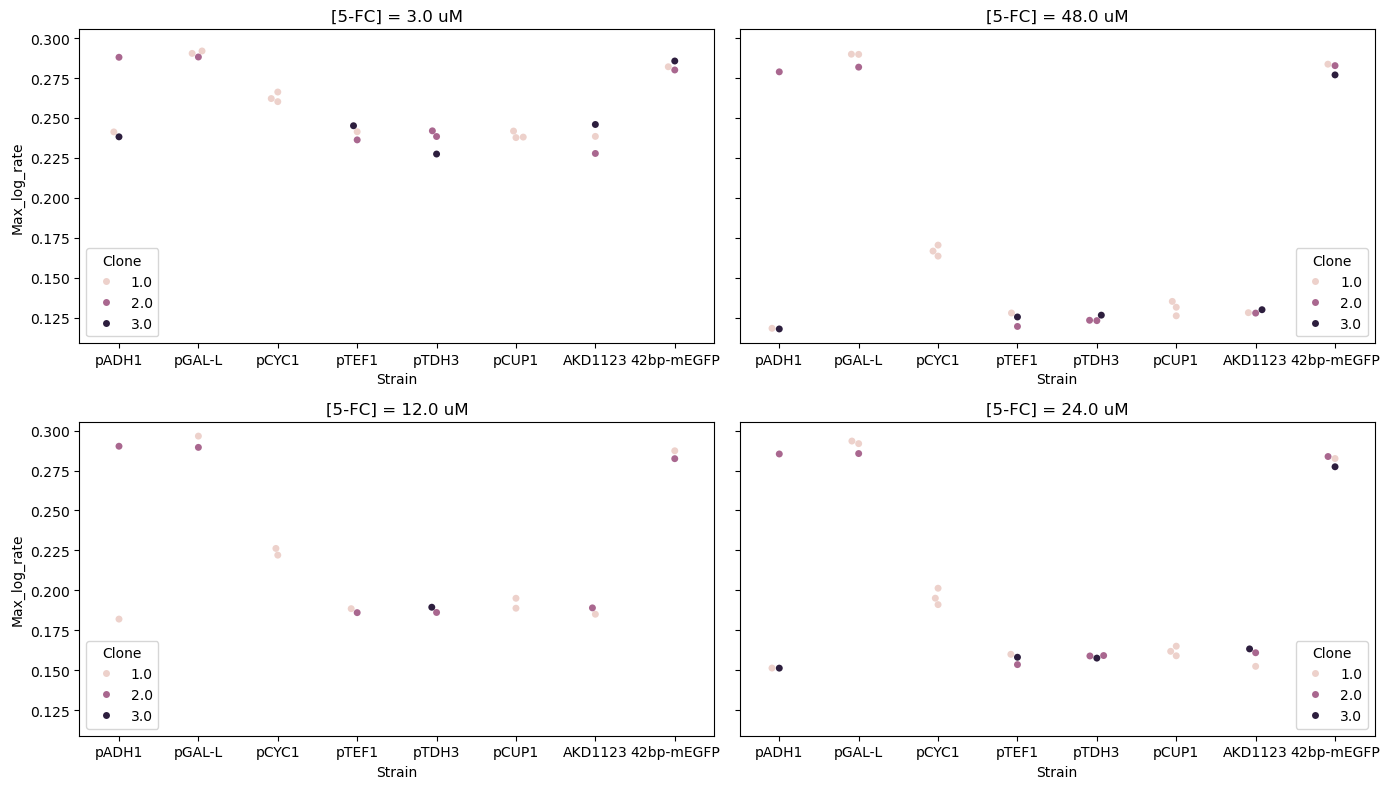

In [36]:
# Max log derivative growth rate
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharey=True, tight_layout=True)
fig_coords = {0:[0,0], 1:[0,1],
              2:[1,0], 3:[1,1]}
fig_num = 0

for conc in rates_1G['[5-FC] (uM)'].copy().dropna().unique():
    rates_subset = rates_1G[rates_1G['[5-FC] (uM)'] == conc].copy().reset_index(drop=True)

    row_num = fig_coords[fig_num][0]
    col_num = fig_coords[fig_num][1]

    sns.swarmplot(data=rates_subset, x='Strain', y='Max_log_rate', hue='Clone', ax=axs[row_num, col_num])
    axs[row_num, col_num].set_title(f'[5-FC] = {conc} uM')

    fig_num += 1

In all cases, clone 2 of pADH1 is clearly an outlier!

Second, in cytosine:

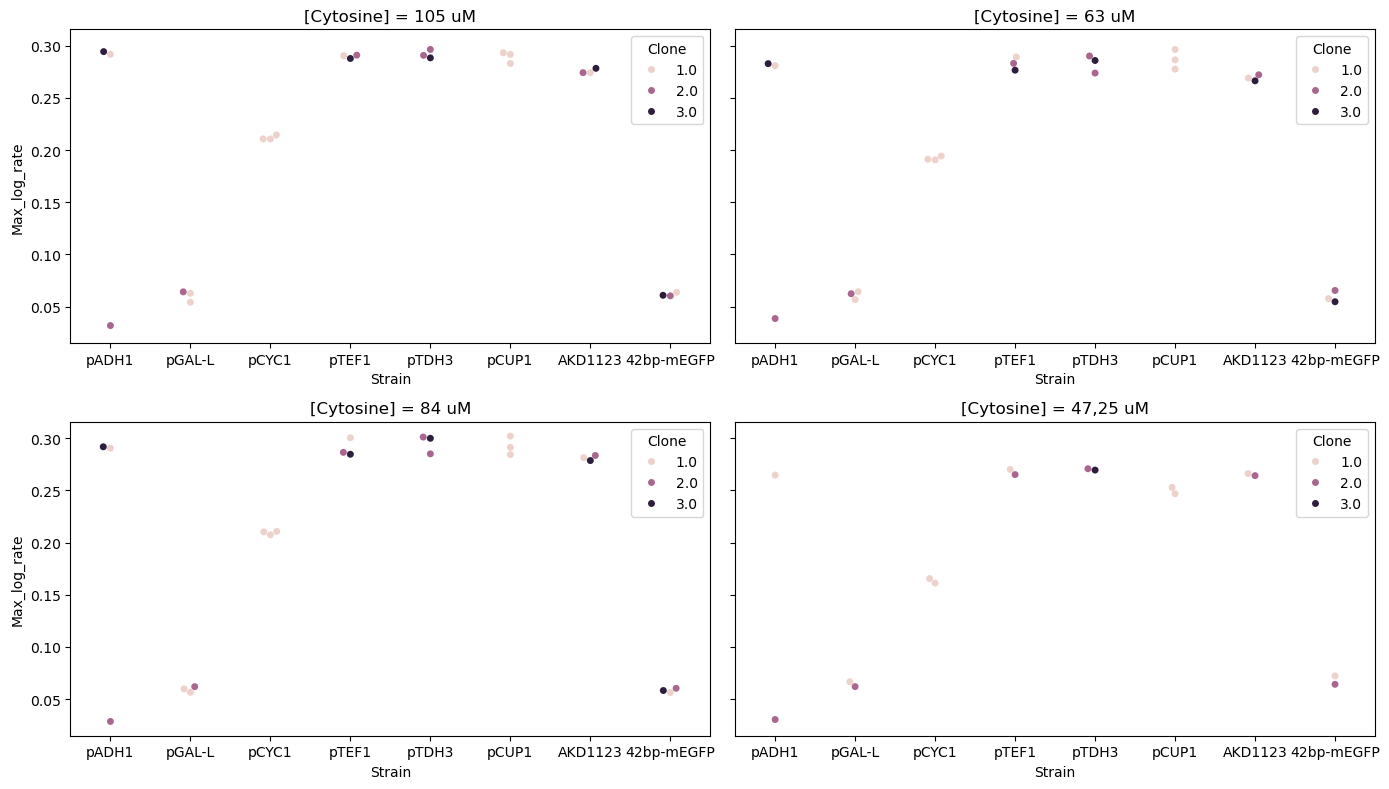

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharey=True, tight_layout=True)
fig_coords = {0:[0,0], 1:[0,1],
              2:[1,0], 3:[1,1]}
fig_num = 0

for conc in rates_2G['[Cytosine] (uM)'].copy().dropna().unique():
    rates_subset = rates_2G[rates_2G['[Cytosine] (uM)'] == conc].copy().reset_index(drop=True)

    row_num = fig_coords[fig_num][0]
    col_num = fig_coords[fig_num][1]

    sns.swarmplot(data=rates_subset, x='Strain', y='Max_log_rate', hue='Clone', ax=axs[row_num, col_num])
    axs[row_num, col_num].set_title(f'[Cytosine] = {conc} uM')

    fig_num += 1

The same replicate (2) of the pADH1 strain remains an outlier.

#### 24-09 data

Text(0.5, 1.0, '[5-FC] = 12uM')

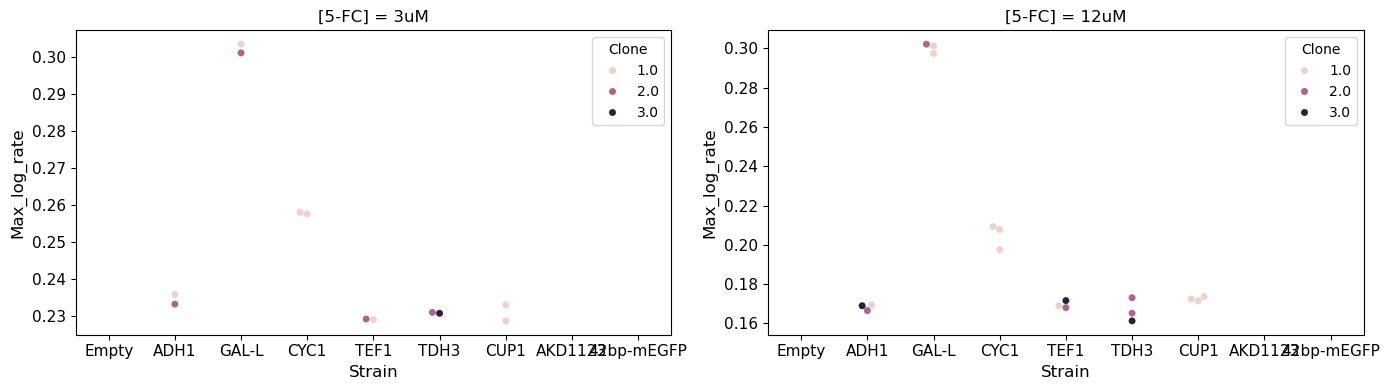

In [269]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4), tight_layout=True)

sns.swarmplot(data=rates_2G_24[rates_2G_24['5-FC (uM)'] == 3], x='Strain', y='Max_log_rate', hue='Clone', ax=axs[0])
axs[0].set_title('[5-FC] = 3uM')

sns.swarmplot(data=rates_2G_24[rates_2G_24['5-FC (uM)'] == 12], x='Strain', y='Max_log_rate', hue='Clone', ax=axs[1])
axs[1].set_title('[5-FC] = 12uM')

In [252]:
rates_2G_24

,Well,Strain,Clone,[5-FC] (uM),Max_log_rate,Label,Experiment
0,B02,pADH1,1.0,12.0,0.169413,pADH1,24-09
1,B03,pGAL-L,1.0,12.0,0.301327,pGAL-L,24-09
2,B04,pADH1,2.0,12.0,0.166512,pADH1,24-09
3,B05,pGAL-L,2.0,12.0,0.302136,pGAL-L,24-09
4,B06,pADH1,3.0,12.0,0.168979,pADH1,24-09
5,B07,pGAL-L,1.0,12.0,0.297441,pGAL-L,24-09
6,B08,pADH1,1.0,3.0,0.235900,pADH1,24-09
7,B09,pGAL-L,1.0,3.0,0.303506,pGAL-L,24-09
8,B10,pADH1,2.0,3.0,0.233315,pADH1,24-09
9,B11,pGAL-L,2.0,3.0,0.301153,pGAL-L,24-09


There are no obvious outliers here!

### Merging the two experiments in 5-FC and validating whether they display systematic differences

In [45]:
# Preparing the 25-02 df
df_25 = rates_1G[(rates_1G['Strain'] != 'pADH1') | (rates_1G['Clone'] != 2)].copy().reset_index(drop=True)
df_25['Experiment'] = '25-02'
df_25 = df_25[df_25['Label'] != 'Blank'].copy().reset_index(drop=True)

# Preparing the 24-09 df
dict_labels = {df_25.at[row_num, 'Strain']: df_25.at[row_num, 'Label'] for row_num in range(df_25.shape[0])}
rates_2G_24 = rates_2G_24.rename(columns={'5-FC (uM)': '[5-FC] (uM)'})
rates_2G_24 = rates_2G_24[rates_2G_24['Strain'] != 'Empty'].copy().reset_index(drop=True)

to_keep = ['AKD1123', '42bp-mEGFP']
rates_2G_24['Strain'] = rates_2G_24['Strain'].apply(lambda x: 'p'+x if x not in to_keep else x)
rates_2G_24['Label'] = rates_2G_24['Strain'].apply(lambda x: dict_labels[x])
rates_2G_24 = rates_2G_24.drop(columns=['Type'])
rates_2G_24['Experiment'] = '24-09'

# Combining the two dfs
rates_5FC_all = pd.concat([df_25, rates_2G_24]).reset_index(drop=True)

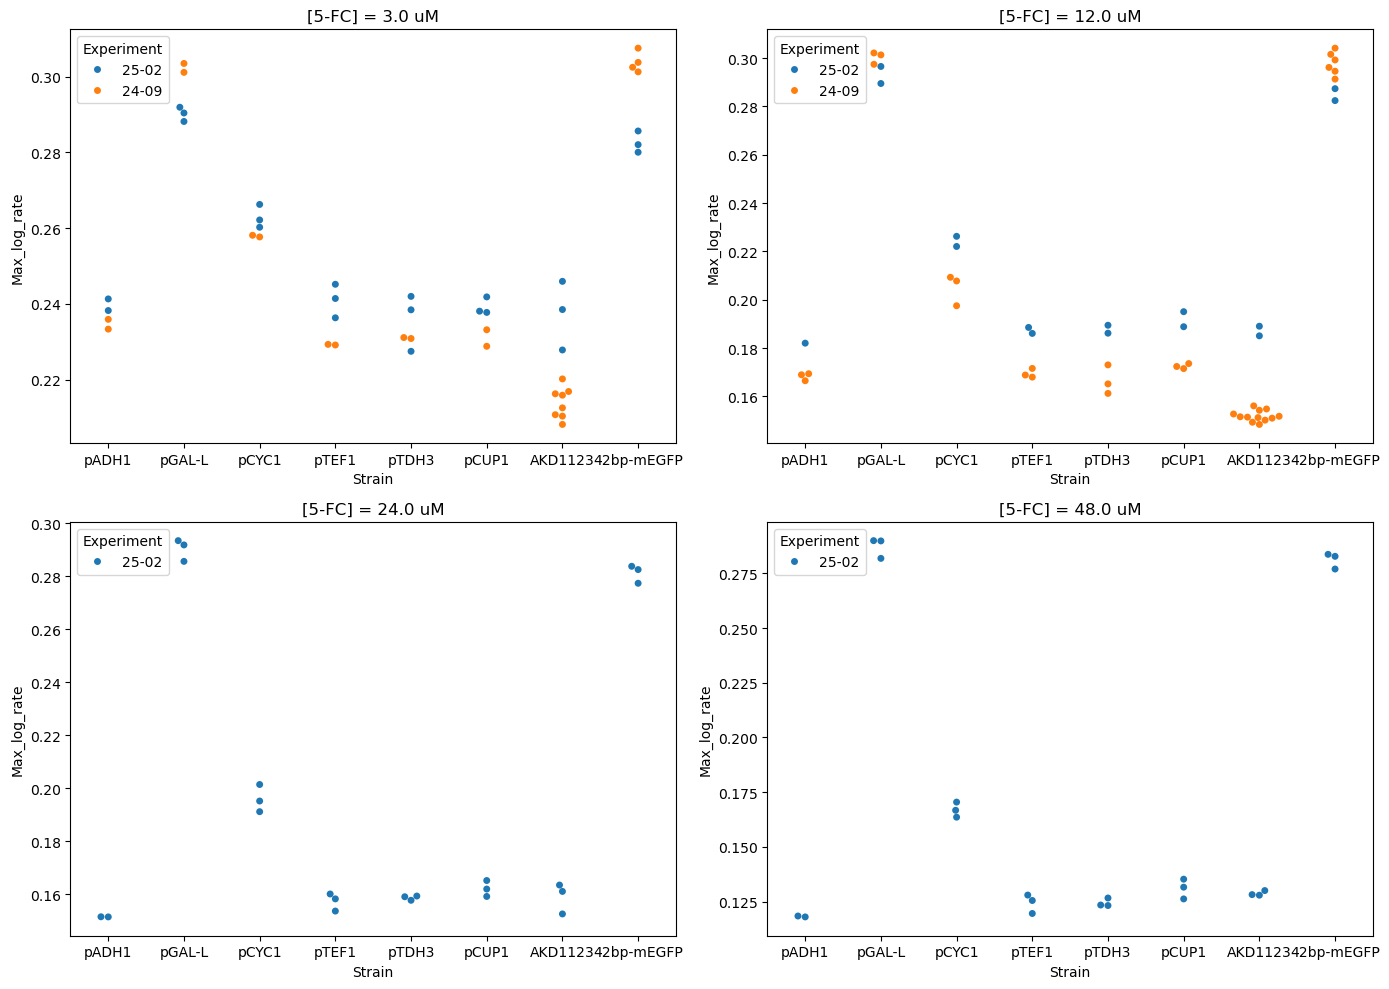

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10), tight_layout=True)
fig_row = 0
fig_col = 0

for conc in np.sort(rates_5FC_all['[5-FC] (uM)'].unique()):
    data_conc = rates_5FC_all[rates_5FC_all['[5-FC] (uM)'] == int(conc)].copy().reset_index(drop=True)
    
    sns.swarmplot(data=data_conc, x='Strain', y='Max_log_rate', hue='Experiment', ax=axs[fig_row, fig_col])
    axs[fig_row, fig_col].set_title(f'[5-FC] = {conc} uM')

    fig_col += 1

    if fig_col == 2:
        fig_row += 1
        fig_col = 0

There seems to be systematic differences between the two experiments. The growth rates in 3 uM and 12 uM 5-FC from 24-09 will be adjusted so that they have the same median as the corresponding 25-02 growth rates.  

In [48]:
# For 12 uM
# Aggregating by strain, to obtain a representative median for each experiment
by_strain_12_24 = rates_5FC_all[(rates_5FC_all['Experiment'] == '24-09') & (rates_5FC_all['[5-FC] (uM)'] == 12)][['Strain', 'Max_log_rate']].copy()
by_strain_12_24 = by_strain_12_24.groupby(by=['Strain'], as_index=False).median()

by_strain_12_25 = rates_5FC_all[(rates_5FC_all['Experiment'] == '25-02') & (rates_5FC_all['[5-FC] (uM)'] == 12)][['Strain', 'Max_log_rate']].copy()
by_strain_12_25 = by_strain_12_25.groupby(by=['Strain'], as_index=False).median()

# Computing the difference between the medians of the two experiments
diff_med_12 = np.median(by_strain_12_25['Max_log_rate']) - np.median(by_strain_12_24['Max_log_rate'])

# Using these differences to adjust the fitness measurements from 24-09
data_12_24 = rates_5FC_all[(rates_5FC_all['Experiment'] == '24-09') & (rates_5FC_all['[5-FC] (uM)'] == 12)].copy().reset_index(drop=True)
data_12_24['Max_log_rate'] = data_12_24['Max_log_rate'] + diff_med_12

# Combining the adjusted 24-09 data with the original 25-02 data
data_12_25 = rates_5FC_all[(rates_5FC_all['Experiment'] == '25-02') & (rates_5FC_all['[5-FC] (uM)'] == 12)].copy().reset_index(drop=True)
data_12um_adj = pd.concat([data_12_25, data_12_24]).reset_index(drop=True)

In [49]:
# For 3 uM
# Aggregating by strain, to obtain a representative median for each experiment
by_strain_3_24 = rates_5FC_all[(rates_5FC_all['Experiment'] == '24-09') & (rates_5FC_all['[5-FC] (uM)'] == 3)][['Strain', 'Max_log_rate']].copy()
by_strain_3_24 = by_strain_3_24.groupby(by=['Strain'], as_index=False).median()

by_strain_3_25 = rates_5FC_all[(rates_5FC_all['Experiment'] == '25-02') & (rates_5FC_all['[5-FC] (uM)'] == 3)][['Strain', 'Max_log_rate']].copy()
by_strain_3_25 = by_strain_3_25.groupby(by=['Strain'], as_index=False).median()

# Computing the difference between the medians of the two experiments
diff_med_3 = np.median(by_strain_3_25['Max_log_rate']) - np.median(by_strain_3_24['Max_log_rate'])

# Using these differences to adjust the fitness measurements from 24-09
data_3_24 = rates_5FC_all[(rates_5FC_all['Experiment'] == '24-09') & (rates_5FC_all['[5-FC] (uM)'] == 3)].copy().reset_index(drop=True)
data_3_24['Max_log_rate'] = data_3_24['Max_log_rate'] + diff_med_3

# Combining the adjusted 24-09 data with the original 25-02 data
data_3_25 = rates_5FC_all[(rates_5FC_all['Experiment'] == '25-02') & (rates_5FC_all['[5-FC] (uM)'] == 3)].copy().reset_index(drop=True)
data_3um_adj = pd.concat([data_3_25, data_3_24]).reset_index(drop=True)

In [50]:
# Final data set of growth rates
conc_not_dupli = rates_5FC_all[(rates_5FC_all['[5-FC] (uM)'] != 12) & (rates_5FC_all['[5-FC] (uM)'] != 3)].copy()
log_rates_5FC = pd.concat([data_3um_adj, conc_not_dupli, data_12um_adj]).reset_index(drop=True)

# For cytosine, no normalization was needed, as we have only one experiment. 
# A renamed dataframe is defined for consistency
log_rates_cyto = rates_2G[(rates_2G['Strain'] != 'pADH1') | (rates_2G['Clone'] != 2)].copy().reset_index(drop=True)

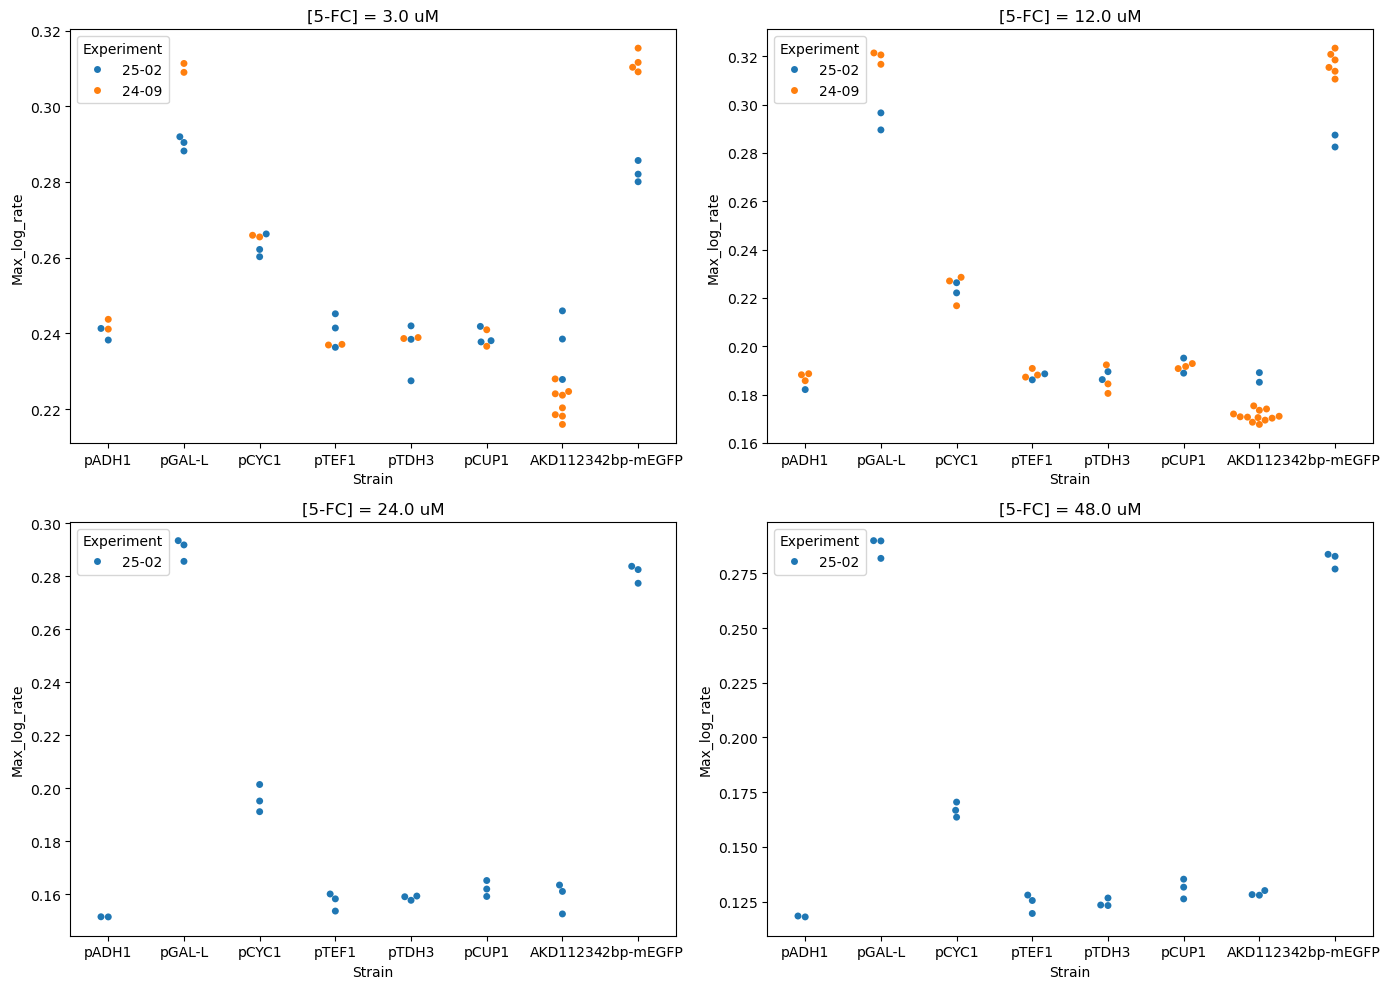

In [51]:
# What do the 5-FC rates look like after normalization?

fig, axs = plt.subplots(2, 2, figsize=(14, 10), tight_layout=True)
fig_row = 0
fig_col = 0

for conc in np.sort(log_rates_5FC['[5-FC] (uM)'].unique()):
    data_conc = log_rates_5FC[log_rates_5FC['[5-FC] (uM)'] == int(conc)].copy().reset_index(drop=True)
    
    sns.swarmplot(data=data_conc, x='Strain', y='Max_log_rate', hue='Experiment', ax=axs[fig_row, fig_col])
    axs[fig_row, fig_col].set_title(f'[5-FC] = {conc} uM')

    fig_col += 1

    if fig_col == 2:
        fig_row += 1
        fig_col = 0

The only strains where a systematic effect remain are the ones which are totaly resistant to 5-FC (pGAL-L and mEGFP). This suggests that media composition varied between the two experiments (although it should not be the case).

The AKD1123 replicates from the 24-09 experiment remain (suspiciously) distinct. They will still be included, such that overfitting on the (likely artefactual) decrease in fitness around WT can be used as a "worst case scenario" for our mutant fitness estimates.

In [54]:
# The fitness of the 42bp-mEGFP strain also won't be used any further
log_rates_5FC = log_rates_5FC[log_rates_5FC['Strain'] != '42bp-mEGFP'].copy().reset_index(drop=True)
log_rates_cyto = log_rates_cyto[log_rates_cyto['Strain'] != '42bp-mEGFP'].copy().reset_index(drop=True)

In [55]:
# Adding an "Experiment" column to log_rates_cyto, although all measurements come from the same experiment
log_rates_cyto['Experiment'] = '25-02'

## 2) Converting fluorescence intensities into into relative expression levels

The fluorescence measurements for all PCR toolbox strains from 25-02 and 24-09 will be combined.

### Creating dictionaries with info on each well from each cytometry plate

In [59]:
# df for 25-02
info_cyto_25 = pd.read_csv("FCY1_fit_func_data/df_plate_cytometry_25-02-17.csv")

# df for 24-09
info_cyto_24 = pd.read_csv("Fit_func_data_24-09/config_2C_24_09_04_SA.csv")[['well', 'Strain', 'Clone', 'Type']].copy()

In [60]:
# Dictionary for 25-02
dict_fluo_25 = {}

for row in range(info_cyto_25.shape[0]):
    well = info_cyto_25.at[row, 'Well']
    strain = info_cyto_25.at[row, 'Strain']
    clone = info_cyto_25.at[row, 'Clone']
    strain_label = info_cyto_25.at[row, 'Label']
    if strain_label == 'FCY1 deletion':
        strain_label = 'Blank'
    
    dict_fluo_25[well] = [strain, clone, strain_label]

# Dictionary for 24-09
dict_fluo_24 = {}

to_label_dict = {'AKD1123': 'Blank', '42bp-mEGFP': 'Wild-type'}

for row in range(info_cyto_24.shape[0]):
    well = info_cyto_24.at[row, 'well']
    strain = info_cyto_24.at[row, 'Strain']
    clone = info_cyto_24.at[row, 'Clone']
    strain_label = info_cyto_24.at[row, 'Type']

    if strain not in ['AKD1123', '42bp-mEGFP']:
        strain = 'p'+ strain
        strain_label = strain
    
    dict_fluo_24[well] = [strain, clone, strain_label]

### Importing the fluorescence data

In [62]:
# First generating the dataframe for the 25-02 data

# Looping over the wells for which we have data
n_iter = 0
for well_num in dict_fluo_25.keys():

    # Try loading the data, if the well has been measured at the cytometer
    file_path = f"FCY1_fit_func_data/2025-02-18_at_04-04-31pm/2025-02-18_at_04-04-31pm.{well_num}.csv"
    try:
        data_all = pd.read_csv(file_path)
    except:
        continue

    # Obtain the data and concatenate in the larger dataframe
    current_df = pd.DataFrame(columns = ['Well', 'Strain', 'Label', 'Clone', "FSC-HLin", "SSC-HLin", "GRN-B-HLin", "YEL-B-HLin"])
    
    strain = dict_fluo_25[well_num][0]
    clone = dict_fluo_25[well_num][1]
    strain_label = dict_fluo_25[well_num][2]
    
    current_df[["FSC-HLin", "SSC-HLin", "GRN-B-HLin", "YEL-B-HLin"]] = data_all[["FSC-HLin", "SSC-HLin", "GRN-B-HLin", "YEL-B-HLin"]].copy()

    current_df['Well'] = well_num
    current_df['Strain'] = strain
    current_df['Label'] = strain_label
    current_df['Clone'] = clone

    if n_iter == 0:
        data_fluo_25 = current_df.copy()

    else:
        data_fluo_25 = pd.concat([data_fluo_25, current_df]).reset_index(drop=True)

    n_iter += 1

In [63]:
# Second, for the 24-09 data
n_iter = 0

for well_num in dict_fluo_24.keys():

    # Try loading the data, if the well has been measured at the cytometer
    file_path = f"Fit_func_data_24-09/2024-09-04_at_06-48-44pm_plate2C/2024-09-04_at_06-48-44pm_plate2C.{well_num}.csv"
    try:
        data_all = pd.read_csv(file_path)
    except:
        continue

    # Obtain the data and concatenate in the larger dataframe
    current_df = pd.DataFrame(columns = ['Well', 'Strain', 'Label', 'Clone', "FSC-HLin", "SSC-HLin", "GRN-B-HLin", "YEL-B-HLin"])
    
    strain = dict_fluo_24[well_num][0]
    clone = dict_fluo_24[well_num][1]
    strain_label = dict_fluo_24[well_num][2]
    
    current_df[["FSC-HLin", "SSC-HLin", "GRN-B-HLin", "YEL-B-HLin"]] = data_all[["FSC-HLin", "SSC-HLin", "GRN-B-HLin", "YEL-B-HLin"]].copy()

    current_df['Well'] = well_num
    current_df['Strain'] = strain
    current_df['Label'] = strain_label
    current_df['Clone'] = clone

    if n_iter == 0:
        data_fluo_24 = current_df.copy()

    else:
        data_fluo_24 = pd.concat([data_fluo_24, current_df]).reset_index(drop=True)

    n_iter += 1


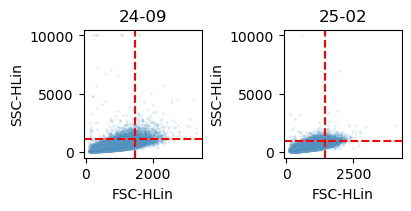

In [64]:
# Establising FSC and SSC thresholds within each plate
fsc_24 = np.percentile(data_fluo_24['FSC-HLin'], 99)
ssc_24 = np.percentile(data_fluo_24['SSC-HLin'], 99)

fsc_25 = np.percentile(data_fluo_25['FSC-HLin'], 99)
ssc_25 = np.percentile(data_fluo_25['SSC-HLin'], 99)

# Validating the thresholds
fig, axs = plt.subplots(1, 2, figsize=(4,2), constrained_layout=True) 
sns.scatterplot(data=data_fluo_24, x='FSC-HLin', y='SSC-HLin', alpha=0.15, s=3, ax=axs[0])
axs[0].set_title('24-09')
axs[0].axhline(y=ssc_24, c='red', linestyle='--')
axs[0].axvline(x=fsc_24, c='red', linestyle='--')


sns.scatterplot(data=data_fluo_25, x='FSC-HLin', y='SSC-HLin', alpha=0.15, s=3, ax=axs[1])
axs[1].set_title('25-02')
axs[1].axhline(y=ssc_25, c='red', linestyle='--')
axs[1].axvline(x=fsc_25, c='red', linestyle='--')

In [65]:
print(f'FSC-24 = {fsc_24}; SSC-24 = {ssc_24}')

FSC-24 = 1467.0113180300002; SSC-24 = 1099.2771518400007


In [66]:
print(f'FSC-25 = {fsc_25}; SSC-25 = {ssc_25}')

FSC-25 = 1440.9001622200005; SSC-25 = 982.1309621900002


Since the two cell populations are comparable, the FSC and SSC thresholds are recomputed on the concatenated data:

In [68]:
fsc_max = np.percentile(pd.concat([data_fluo_24['FSC-HLin'], data_fluo_25['FSC-HLin']]), 99)
ssc_max = np.percentile(pd.concat([data_fluo_24['SSC-HLin'], data_fluo_25['SSC-HLin']]), 99)

#### Are there outliers within each dataset?

Basic normalization (by SSC) and log10 transformation are performed:

In [71]:
# Applying the thresholds
data_fluo_25 = data_fluo_25[(data_fluo_25['FSC-HLin'] < fsc_max) & (data_fluo_25['SSC-HLin'] < ssc_max)].copy().reset_index(drop=True)
data_fluo_24 = data_fluo_24[(data_fluo_24['FSC-HLin'] < fsc_max) & (data_fluo_24['SSC-HLin'] < ssc_max)].copy().reset_index(drop=True)

# Dividing by the FSC
data_fluo_25['GRN-B-HLin'] = data_fluo_25['GRN-B-HLin'] / data_fluo_25['FSC-HLin']
data_fluo_25['YEL-B-HLin'] = data_fluo_25['YEL-B-HLin'] / data_fluo_25['FSC-HLin']

data_fluo_24['GRN-B-HLin'] = data_fluo_24['GRN-B-HLin'] / data_fluo_24['FSC-HLin']
data_fluo_24['YEL-B-HLin'] = data_fluo_24['YEL-B-HLin'] / data_fluo_24['FSC-HLin']

# Subtracting the blank, separately within each plate
data_fluo_25['GRN-B-HLin'] = data_fluo_25['GRN-B-HLin'] - np.median(data_fluo_25[data_fluo_25['Label'] == 'Blank']['GRN-B-HLin'])
data_fluo_24['GRN-B-HLin'] = data_fluo_24['GRN-B-HLin'] - np.median(data_fluo_24[data_fluo_24['Label'] == 'Blank']['GRN-B-HLin'])

data_fluo_25['YEL-B-HLin'] = data_fluo_25['YEL-B-HLin'] - np.median(data_fluo_25[data_fluo_25['Label'] == 'Blank']['YEL-B-HLin'])
data_fluo_24['YEL-B-HLin'] = data_fluo_24['YEL-B-HLin'] - np.median(data_fluo_24[data_fluo_24['Label'] == 'Blank']['YEL-B-HLin'])

# Genrating log10-scaled columns
data_fluo_25['Log10_GRN'] = np.log10(data_fluo_25['GRN-B-HLin'])
data_fluo_25['Log10_YEL'] = np.log10(data_fluo_25['YEL-B-HLin'])

data_fluo_24['Log10_GRN'] = np.log10(data_fluo_24['GRN-B-HLin'])
data_fluo_24['Log10_YEL'] = np.log10(data_fluo_24['YEL-B-HLin'])

F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, '24-09')

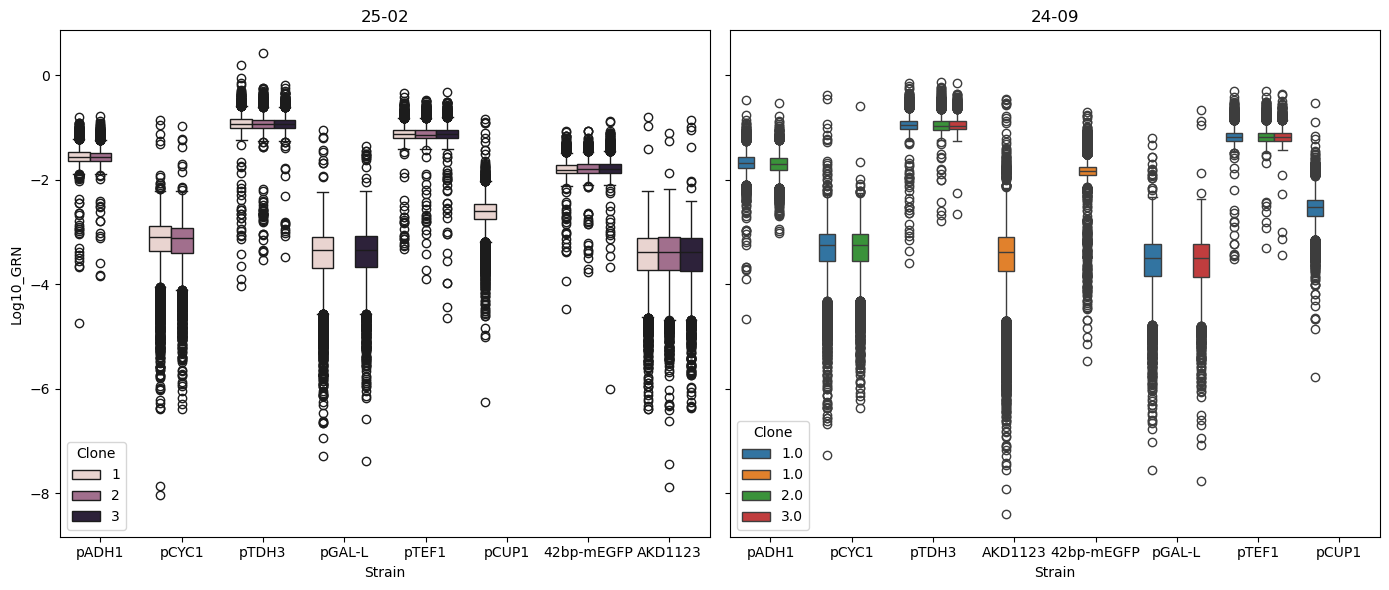

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True, tight_layout=True)

sns.boxplot(data=data_fluo_25, x='Strain', y='Log10_GRN', hue='Clone', ax=axs[0])
axs[0].set_title('25-02')

data_fluo_24['Clone'] = data_fluo_24['Clone'].fillna('1.0')
sns.boxplot(data=data_fluo_24, x='Strain', y='Log10_GRN', hue='Clone', ax=axs[1])
axs[1].set_title('24-09')

There are no obvious outliers and the median are very consistent across experiments. Let's make sure that it is truly the case:

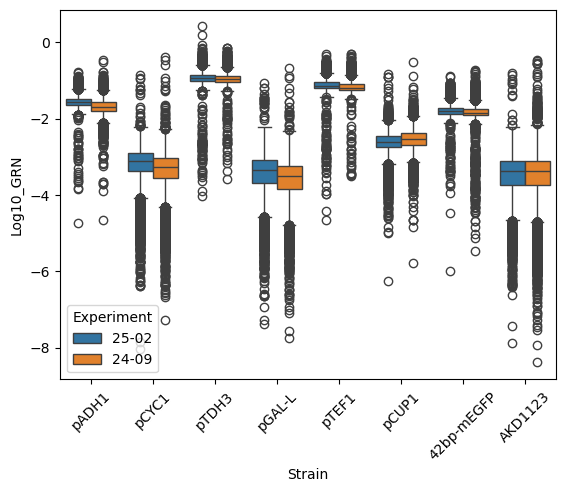

In [74]:
data_fluo_25['Experiment'] = '25-02'
data_fluo_24['Experiment'] = '24-09'

data_fluo_all = pd.concat([data_fluo_25, data_fluo_24]).reset_index(drop=True)

sns.boxplot(data=data_fluo_all, x='Strain', y='Log10_GRN', hue='Experiment')
plt.gca().tick_params(axis='x', labelrotation=45)

There seems to be systematic differences, except for strains pCUP1 and AKD1123. Maybe it's more rigourous to keep this uncertainty for the upcoming bootstrapping of mutant fitness values. 

### Converting fluorescence intensities into WT-relative expression levels

#### Combining the two sets of measurements

In [78]:
data_24_bywell = data_fluo_24.drop(columns='Clone').copy()
data_24_bywell = data_24_bywell.groupby(by=['Experiment', 'Well', 'Strain', 'Label'], as_index=False).median()
data_24_bywell['Median_rel_exp'] = data_24_bywell['GRN-B-HLin'] / np.median(data_24_bywell[data_24_bywell['Label'] == 'Wild-type']['GRN-B-HLin'])

data_25_bywell = data_fluo_25.drop(columns='Clone').copy()
data_25_bywell = data_25_bywell.groupby(by=['Experiment', 'Well', 'Strain', 'Label'], as_index=False).median()
data_25_bywell['Median_rel_exp'] = data_25_bywell['GRN-B-HLin'] / np.median(data_25_bywell[data_25_bywell['Label'] == 'Wild-type']['GRN-B-HLin'])

data_fluo_bywell = pd.concat([data_25_bywell, data_24_bywell]).reset_index(drop=True)

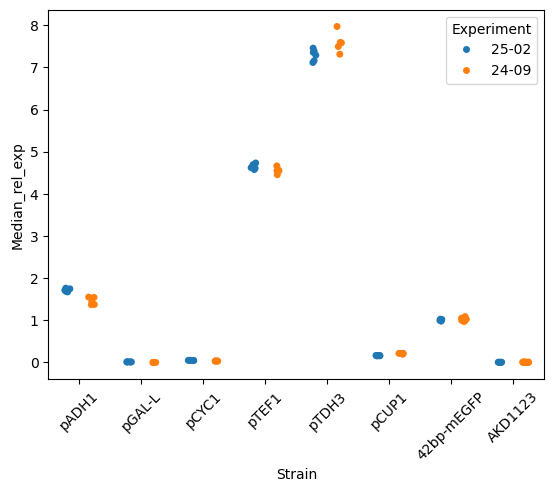

In [79]:
sns.stripplot(data=data_fluo_bywell, x='Strain', y='Median_rel_exp', hue='Experiment', dodge=True)
plt.gca().tick_params(axis='x', labelrotation=45)

In [80]:
data_fluo_bywell[['Strain', 'Median_rel_exp']].copy().groupby(by=['Strain'], as_index=False).mean()

,Strain,Median_rel_exp
0,42bp-mEGFP,1.007406
1,AKD1123,0.000046
2,pADH1,1.596279
3,pCUP1,0.180294
4,pCYC1,0.037077
5,pGAL-L,0.003089
6,pTDH3,7.428678
7,pTEF1,4.601463


There are small differences for some promoters, but the two sets of measurements are highly consistent in most cases. If the bootstrapped fitness estimates are robust to this variation, it will further validate our DMS results!

## Fitting the expression-fitness relationship and estimating effects of F3-F4 mutations by bootstrapping

The expression-fitness relationship will be fit in two ways: 1) Using an exponential decay model and 2) Using modified Akima (makima) interpolation.

In [118]:
# defining a basic exponential decay function
def basic_decay(x, init_exp, mu, c):
    return init_exp * np.exp(-mu * x) + c

Both types of curves will be fit for each concentration of 5-FC and cytosine, within a bootstrapping routine.

When trying to infer the fitness of F3-F4 mutants, the estimation of their expression levels will be repeated, using the same seed as in Sort_calibration.ipynb 

### Defining functions for the bootstrapping routine

In [120]:
def get_percentiles(percentiles, boot_array, var_name, out_df):
    """Function which takes the output array of a bootstrapping routine and returns the desired percentiles.
       In addition, the median is automatically computed. For each series of percentile, a new column is created in a copy of the specified out_df."""
    funct_df = out_df.copy()
    med_name = f'Median_{var_name}'
    med_column = np.median(boot_array, axis=1)
    funct_df[med_name] = med_column

    for percent_val in percentiles:
        num_split = str(percent_val).split('.')
        percent_str = '_'.join(num_split)
        percent_name = f'{var_name}_{percent_str}'
        percent_column = np.percentile(boot_array, percent_val, axis=1)
        funct_df[percent_name] = percent_column

    return funct_df

In [122]:
def fit_sort_exp(sort_all_df, ordered_genotypes, genotype_col, score_name, sort_val_df, fluo_df, rng_to_use):
    """Function to fit the relationship between sort-seq scores and relative expression levels.
       Performs only one iteration of the fitting.
       sort_all_df = Dataframe containing all replicate sort-seq measurements
       ordered_genotypes = List of genotypes labels for which to predict relative expression levels
       genotype_col = Name of the column containing genotype labels (same in all used dfs)
       score_name = Column in sort_all_df to use as sort-seq score
       sort_val_df = Dataframe containing data on validation mutants used to calibrate sort-seq.
                     Its {genotype_col} column is used to extract the list of validation genotypes.
       fluo_df = Dataframe with relative median expression measurements for validaition mutants (per well).
       rng_to_use = Instance of np.random.default_rng() to use in the current routine.
                    The corresponding column should be named 'Relative_median_exp'."""

    # Preparing the df which will contain the current median sort-seq scores
    median_diffs = pd.DataFrame(index=ordered_genotypes, columns=['Median_delta_WT'])

    # Assembling a dataset of median Delta Ref scores by sampling measurements with replacement
    for mutant in ordered_genotypes:
        scores_subset = sort_all_df[sort_all_df[genotype_col] == mutant].copy().reset_index(drop=True)
        n_observed = scores_subset.shape[0]
        sampled_diffs = rng_to_use.choice(scores_subset[score_name].values, size=n_observed, replace=True)
        current_median = np.median(sampled_diffs)
        median_diffs.at[mutant, 'Median_delta_WT'] = current_median
        
    median_diffs = median_diffs.infer_objects()

    # Assembling a corresponding validation set
    val_genotypes = list(np.sort(sort_val_df[genotype_col].unique()))
    val_df = median_diffs.loc[val_genotypes, :].copy()
    val_df[genotype_col] = val_df.index
    val_df['Relative_median_exp'] = pd.Series(dtype='float64')

    for val_mutant in val_genotypes:
        exp_subset = fluo_df[fluo_df[genotype_col] == val_mutant].copy().reset_index(drop=True)
        exp_points = exp_subset.shape[0]
        sampled_exp = rng_to_use.choice(exp_subset['Relative_median_exp'].values, size=exp_points, replace=True)
        current_exp = np.median(sampled_exp)
        val_df.at[val_mutant, 'Relative_median_exp'] = current_exp
        
    val_df = val_df.infer_objects()

    # Fitting the lowess and predicting expression levels
    pred_res = sm.nonparametric.lowess(exog=val_df['Median_delta_WT'].values, endog=val_df['Relative_median_exp'].values,
                                       xvals=median_diffs['Median_delta_WT'].values)

    return pred_res

In [124]:
def fit_exp_growth(fluo_prom_df, growth_prom_df, prom_col, experiment_col, rel_exp_col, growth_col, rng_to_use, eval_fit, 
                   mutant_exp=None, max_iter=None):
    """Function to fit the relationship between relative expression level and (exponential) growth rate.
    Also performs only one iteration of the fitting (both using exponential decay and makima interpolation.
    fluo_prom_df = Dataframe containing replicate measurements of median relative fluorescence (expression) for constitutive promoters
    growth_prom_df = Dataframe containing replicate growth rate measurements (at one chosen concentration of 5-FC or cytosine) for the same promoters
    prom_col = Name of the column containing the unique labels for the different promoters
    experiment_col = Name of the column containing identifiers for different sets of measurements (experiments on different days from different cultures)
    The two previous '_col' arguments are shared for both input dataframes.
    rel_exp_col = Name of the column with relative median expression measurements, in fluo_prom_df
    growth_col = Name of the column containing growth rate measurements, in growth_prom_df
    rng_to_use = Instance of np.random.default_rng() to use in the current call for sampling with replacement
    eval_fit = Series of WT-relative epression levels at which the evaluate the newly fit exp->growth relationship
    mutant_exp_df = Array of mutant expression levels. Mutant growth rates are predicted if it is provided."""
    
    # Redefining both dataframes as copies containing only the columns of interest
    fluo_prom_df = fluo_prom_df[[prom_col, experiment_col, rel_exp_col]].copy()
    growth_prom_df = growth_prom_df[[prom_col, experiment_col, growth_col]].copy()
    
    # Initializing the sampling of growth and expression measurements
    n_prom = 0
    ordered_proms = np.sort(fluo_prom_df[prom_col].unique())
    
    for prom in ordered_proms:
        
        if prom == 'Blank':
            continue
            
        # Sampling fluorescence intensities for the same promoter
        if len(list(fluo_prom_df[experiment_col].unique())) > 1:
            n_exp = 0

            for fluo_experiment in np.sort(fluo_prom_df[experiment_col].unique()):
                current_exp = fluo_prom_df[fluo_prom_df[experiment_col] == fluo_experiment].copy().reset_index(drop=True)
                exp_subset = current_exp[current_exp[prom_col] == prom].copy().reset_index(drop=True)
                exp_to_samp = rng_to_use.choice(exp_subset.index, size=2, replace=True)
                exp_sampled = exp_subset.loc[exp_to_samp, [prom_col, rel_exp_col]].copy()

                if n_exp == 0:
                    cyto_combined = exp_sampled.copy()

                else:
                    cyto_combined = pd.concat([cyto_combined, exp_sampled]).reset_index(drop=True)
                    
                n_exp += 1

            # Sampling with replacement from the four resulting observation
            cyto_to_samp = rng_to_use.choice(cyto_combined.index, size=4, replace=True)
            cyto_sampled = cyto_combined.loc[cyto_to_samp, [prom_col, rel_exp_col]].copy().reset_index(drop=True)
            cyto_sampled['Replicate'] = [1, 2, 3, 4]

        # If measurements come from only one experiment, n observations are sampled with replacement
        else:
            prom_subset = fluo_prom_df[fluo_prom_df[prom_col] == prom].copy().reset_index(drop=True)
            n_mes = prom_subset.shape[0]
            cyto_to_samp = rng_to_use.choice(prom_subset.index, size=n_mes, replace=True)
            cyto_sampled = prom_subset.loc[cyto_to_samp, [prom_col, rel_exp_col]].copy().reset_index(drop=True)
            cyto_sampled['Replicate'] = list(range(1, n_mes+1))

        # Sampling growth rates for the same promoter
        if len(list(growth_prom_df[experiment_col].unique())) > 1:
            n_exp = 0

            for growth_experiment in np.sort(growth_prom_df[experiment_col].unique()):
                current_growth = growth_prom_df[growth_prom_df[experiment_col] == growth_experiment].copy().reset_index(drop=True)
                growth_subset = current_growth[current_growth[prom_col] == prom].copy().reset_index(drop=True)
                growth_to_samp = rng_to_use.choice(growth_subset.index, size=2, replace=True)
                growth_sampled = growth_subset.loc[growth_to_samp, [prom_col, growth_col]].copy()

                if n_exp == 0:
                    growth_combined = growth_sampled.copy()

                else:
                    growth_combined = pd.concat([growth_combined, growth_sampled]).reset_index(drop=True)
                    
                n_exp += 1

            # Sampling with replacement from the four resulting observation
            tecan_to_samp = rng_to_use.choice(growth_combined.index, size=4, replace=True)
            tecan_sampled = growth_combined.loc[tecan_to_samp, [prom_col, growth_col]].copy().reset_index(drop=True)
            tecan_sampled['Replicate'] = [1, 2, 3, 4]

        # If measurements come from only one experiment, n growth rates are sampled with replacement
        else:
            prom_subset = growth_prom_df[growth_prom_df[prom_col] == prom].copy().reset_index(drop=True)
            n_mes = prom_subset.shape[0]
            tecan_to_samp = rng_to_use.choice(prom_subset.index, size=n_mes, replace=True)
            tecan_sampled = prom_subset.loc[tecan_to_samp, [prom_col, growth_col]].copy().reset_index(drop=True)
            tecan_sampled['Replicate'] = list(range(1, n_mes+1))

        # Merging the dataframes of expression levels and growth rates for the current promoter.
        # The smallest number of sampled observations is kept as merged datapoints
        if n_prom == 0:
            combined_current = pd.merge(tecan_sampled, cyto_sampled, on=[prom_col, 'Replicate'], how='outer').reset_index(drop=True)
            combined_current = combined_current.dropna().reset_index(drop=True)  # Removes unmatched observations
            
        else:
            df_current = pd.merge(tecan_sampled, cyto_sampled, on=[prom_col, 'Replicate'], how='outer').reset_index(drop=True)
            df_current = df_current.dropna().reset_index(drop=True)  # Removes unmatched observations
            combined_current = pd.concat([combined_current, df_current]).reset_index(drop=True)

        n_prom += 1

    # Once a set of datapoints has been assembled, the fitness function is fit, using two approaches

    # Generating another version of the df, aggregated into medians (for makima interpolation)
    combined_medians = combined_current.copy().drop(columns=['Replicate'])
    combined_medians = combined_medians.groupby(by=[prom_col], as_index=False).median()
    combined_medians[rel_exp_col] = np.where(combined_medians[rel_exp_col] < 0, 0.01, combined_medians[rel_exp_col])  # Make sure all are positive
    combined_medians = combined_medians.sort_values(by=[rel_exp_col]).reset_index(drop=True)  # Sort for interpolation

    # Fitting an exponential decay fonction
    if max_iter is not None:
        fit_decay, cov_decay = curve_fit(basic_decay, combined_current[rel_exp_col], combined_current[growth_col], maxfev=max_iter)

    else:
        fit_decay, cov_decay = curve_fit(basic_decay, combined_current[rel_exp_col], combined_current[growth_col])

    # Defining a makima interpolator (with extrapolation)
    fit_makima = Akima1DInterpolator(combined_medians[rel_exp_col].values, combined_medians[growth_col].values, method='makima', extrapolate=True)

    # Evaluting the two fits to obtain fitness functions
    curve_decay = basic_decay(eval_fit, fit_decay[0], fit_decay[1], fit_decay[2])
    curve_makima = fit_makima(eval_fit)

    # If estimated mutant expression levels have been given, predict the corresponding growth rates
    if mutant_exp is not None:
        pred_decay = basic_decay(mutant_exp, fit_decay[0], fit_decay[1], fit_decay[2])
        pred_makima = fit_makima(mutant_exp)

    # Return the outputs of the current call
    if mutant_exp is not None:
        return curve_decay, curve_makima, pred_decay, pred_makima

    else:
        return curve_decay, curve_makima  

### Assembling and performing the bootstrapping routine

In [126]:
# Importing the data for SortSeq -> rel expression relationship
sort_all_reps = pd.read_csv("Supp_data/Sort_scores_by_rep_all.csv")
sort_comp = pd.read_csv('Supp_data/Sort_valid_comp.csv')
fluo_agg_1 = pd.read_csv('Supp_data/fluo_by_well_validation.csv')

In [128]:
# Defining variables and random number generators
n_iter = 5000
all_ordered = np.sort(sort_all_reps['Genotype'].unique())
eval_fit_vals = np.linspace(0, 7.5, num=250)
rng_sort = np.random.default_rng(677165)
# One rng for each condition, all with the same seed
rng_5FC_3 = np.random.default_rng(250708)
rng_5FC_12 = np.random.default_rng(250708)
rng_5FC_24 = np.random.default_rng(250708)
rng_5FC_48 = np.random.default_rng(250708)
rng_cyto_47 = np.random.default_rng(250708)
rng_cyto_63 = np.random.default_rng(250708)
rng_cyto_84 = np.random.default_rng(250708)
rng_cyto_105 = np.random.default_rng(250708)

# Defining the data subsets for each condition
growth_5FC_3 = log_rates_5FC[log_rates_5FC['[5-FC] (uM)'] == 3].copy().reset_index(drop=True)
growth_5FC_12 = log_rates_5FC[log_rates_5FC['[5-FC] (uM)'] == 12].copy().reset_index(drop=True)
growth_5FC_24 = log_rates_5FC[log_rates_5FC['[5-FC] (uM)'] == 24].copy().reset_index(drop=True)
growth_5FC_48 = log_rates_5FC[log_rates_5FC['[5-FC] (uM)'] == 48].copy().reset_index(drop=True)

growth_cyto_47 = log_rates_cyto[log_rates_cyto['[Cytosine] (uM)'] == '47,25'].copy().reset_index(drop=True)
growth_cyto_63 = log_rates_cyto[log_rates_cyto['[Cytosine] (uM)'] == '63'].copy().reset_index(drop=True)
growth_cyto_84 = log_rates_cyto[log_rates_cyto['[Cytosine] (uM)'] == '84'].copy().reset_index(drop=True)
growth_cyto_105 = log_rates_cyto[log_rates_cyto['[Cytosine] (uM)'] == '105'].copy().reset_index(drop=True)

In [954]:
# Performing the full bootstrapping routine
for iter_n in range(n_iter):

    #  Predict mutant WT-relative expression levels from sort-seq scores
    pred_mut_exp = fit_sort_exp(sort_all_reps, all_ordered, 'Genotype', 'Diff_bin_cell_norm', sort_comp, fluo_agg_1, rng_sort)

    # Fit the expression->fitness curves, predicting mutant growth rates only for [12 uM] 5-FC

    # A) 5-FC fits
    fits_5FC_3 = fit_exp_growth(data_fluo_bywell, growth_5FC_3, 'Label', 'Experiment', 'Median_rel_exp', 'Max_log_rate', rng_5FC_3, eval_fit_vals, mutant_exp=None)
    fits_5FC_12 = fit_exp_growth(data_fluo_bywell, growth_5FC_12, 'Label', 'Experiment', 'Median_rel_exp', 'Max_log_rate', rng_5FC_12, eval_fit_vals,
                                   mutant_exp=pred_mut_exp)
    fits_5FC_24 = fit_exp_growth(data_fluo_bywell, growth_5FC_24, 'Label', 'Experiment', 'Median_rel_exp', 'Max_log_rate', rng_5FC_24, eval_fit_vals, mutant_exp=None)
    fits_5FC_48 = fit_exp_growth(data_fluo_bywell, growth_5FC_48, 'Label', 'Experiment', 'Median_rel_exp', 'Max_log_rate', rng_5FC_48, eval_fit_vals, mutant_exp=None)

    # B) Cytosine fits
    fits_cyto_47 = fit_exp_growth(data_fluo_bywell, growth_cyto_47, 'Label', 'Experiment', 'Median_rel_exp', 'Max_log_rate', rng_cyto_47, eval_fit_vals, 
                                  mutant_exp=None, max_iter=1600)
    fits_cyto_63 = fit_exp_growth(data_fluo_bywell, growth_cyto_63, 'Label', 'Experiment', 'Median_rel_exp', 'Max_log_rate', rng_cyto_63, eval_fit_vals, 
                                  mutant_exp=None, max_iter=1600)
    fits_cyto_84 = fit_exp_growth(data_fluo_bywell, growth_cyto_84, 'Label', 'Experiment', 'Median_rel_exp', 'Max_log_rate', rng_cyto_84, eval_fit_vals, 
                                  mutant_exp=None, max_iter=1600)
    fits_cyto_105 = fit_exp_growth(data_fluo_bywell, growth_cyto_105, 'Label', 'Experiment', 'Median_rel_exp', 'Max_log_rate', rng_cyto_105, eval_fit_vals, 
                                   mutant_exp=None, max_iter=1600)

    # Saving the results
    if iter_n == 0:
        # Growth functions
        curve_decay_5FC_3 = fits_5FC_3[0].copy().reshape(fits_5FC_3[0].shape[0], 1)
        curve_decay_5FC_12 = fits_5FC_12[0].copy().reshape(fits_5FC_12[0].shape[0], 1)
        curve_decay_5FC_24 = fits_5FC_24[0].copy().reshape(fits_5FC_24[0].shape[0], 1)
        curve_decay_5FC_48 = fits_5FC_48[0].copy().reshape(fits_5FC_48[0].shape[0], 1)

        curve_makima_5FC_3 = fits_5FC_3[1].copy().reshape(fits_5FC_3[1].shape[0], 1)
        curve_makima_5FC_12 = fits_5FC_12[1].copy().reshape(fits_5FC_12[1].shape[0], 1)
        curve_makima_5FC_24 = fits_5FC_24[1].copy().reshape(fits_5FC_24[1].shape[0], 1)
        curve_makima_5FC_48 = fits_5FC_48[1].copy().reshape(fits_5FC_48[1].shape[0], 1)

        curve_decay_cyto_47 = fits_cyto_47[0].copy().reshape(fits_cyto_47[0].shape[0], 1)
        curve_decay_cyto_63 = fits_cyto_63[0].copy().reshape(fits_cyto_63[0].shape[0], 1)
        curve_decay_cyto_84 = fits_cyto_84[0].copy().reshape(fits_cyto_84[0].shape[0], 1)
        curve_decay_cyto_105 = fits_cyto_105[0].copy().reshape(fits_cyto_105[0].shape[0], 1)

        curve_makima_cyto_47 = fits_cyto_47[1].copy().reshape(fits_cyto_47[1].shape[0], 1)
        curve_makima_cyto_63 = fits_cyto_63[1].copy().reshape(fits_cyto_63[1].shape[0], 1)
        curve_makima_cyto_84 = fits_cyto_84[1].copy().reshape(fits_cyto_84[1].shape[0], 1)
        curve_makima_cyto_105 = fits_cyto_105[1].copy().reshape(fits_cyto_105[1].shape[0], 1)

        # Predicted fitness at [12 uM] 5-FC
        fit_muts_decay = fits_5FC_12[2].copy().reshape(fits_5FC_12[2].shape[0], 1)
        fit_muts_makima = fits_5FC_12[3].copy().reshape(fits_5FC_12[3].shape[0], 1)

    else:
        curve_decay_5FC_3  = np.concatenate((curve_decay_5FC_3, fits_5FC_3[0].copy().reshape(fits_5FC_3[0].shape[0], 1)), axis=1)
        curve_decay_5FC_12  = np.concatenate((curve_decay_5FC_12, fits_5FC_12[0].copy().reshape(fits_5FC_12[0].shape[0], 1)), axis=1)
        curve_decay_5FC_24  = np.concatenate((curve_decay_5FC_24, fits_5FC_24[0].copy().reshape(fits_5FC_24[0].shape[0], 1)), axis=1)
        curve_decay_5FC_48  = np.concatenate((curve_decay_5FC_48, fits_5FC_48[0].copy().reshape(fits_5FC_48[0].shape[0], 1)), axis=1)

        curve_makima_5FC_3  = np.concatenate((curve_makima_5FC_3, fits_5FC_3[1].copy().reshape(fits_5FC_3[1].shape[0], 1)), axis=1)
        curve_makima_5FC_12  = np.concatenate((curve_makima_5FC_12, fits_5FC_12[1].copy().reshape(fits_5FC_12[1].shape[0], 1)), axis=1)
        curve_makima_5FC_24  = np.concatenate((curve_makima_5FC_24, fits_5FC_24[1].copy().reshape(fits_5FC_24[1].shape[0], 1)), axis=1)
        curve_makima_5FC_48  = np.concatenate((curve_makima_5FC_48, fits_5FC_48[1].copy().reshape(fits_5FC_48[1].shape[0], 1)), axis=1)

        curve_decay_cyto_47  = np.concatenate((curve_decay_cyto_47, fits_cyto_47[0].copy().reshape(fits_cyto_47[0].shape[0], 1)), axis=1)
        curve_decay_cyto_63  = np.concatenate((curve_decay_cyto_63, fits_cyto_63[0].copy().reshape(fits_cyto_63[0].shape[0], 1)), axis=1)
        curve_decay_cyto_84  = np.concatenate((curve_decay_cyto_84, fits_cyto_84[0].copy().reshape(fits_cyto_84[0].shape[0], 1)), axis=1)
        curve_decay_cyto_105  = np.concatenate((curve_decay_cyto_105, fits_cyto_105[0].copy().reshape(fits_cyto_105[0].shape[0], 1)), axis=1)
        
        curve_makima_cyto_47  = np.concatenate((curve_makima_cyto_47, fits_cyto_47[1].copy().reshape(fits_cyto_47[1].shape[0], 1)), axis=1)
        curve_makima_cyto_63  = np.concatenate((curve_makima_cyto_63, fits_cyto_63[1].copy().reshape(fits_cyto_63[1].shape[0], 1)), axis=1)
        curve_makima_cyto_84  = np.concatenate((curve_makima_cyto_84, fits_cyto_84[1].copy().reshape(fits_cyto_84[1].shape[0], 1)), axis=1)
        curve_makima_cyto_105  = np.concatenate((curve_makima_cyto_105, fits_cyto_105[1].copy().reshape(fits_cyto_105[1].shape[0], 1)), axis=1)

        fit_muts_decay  = np.concatenate((fit_muts_decay, fits_5FC_12[2].copy().reshape(fits_5FC_12[2].shape[0], 1)), axis=1)
        fit_muts_makima  = np.concatenate((fit_muts_makima, fits_5FC_12[3].copy().reshape(fits_5FC_12[3].shape[0], 1)), axis=1)

In [955]:
# Computing confidence intervals
curves_ci_5FC = pd.DataFrame()
curves_ci_5FC['Median_rel_exp'] = eval_fit_vals
curves_ci_5FC = get_percentiles([2.5, 97.5], curve_decay_5FC_3, 'decay_5FC_3', curves_ci_5FC)
curves_ci_5FC = get_percentiles([2.5, 97.5], curve_decay_5FC_12, 'decay_5FC_12', curves_ci_5FC)
curves_ci_5FC = get_percentiles([2.5, 97.5], curve_decay_5FC_24, 'decay_5FC_24', curves_ci_5FC)
curves_ci_5FC = get_percentiles([2.5, 97.5], curve_decay_5FC_48, 'decay_5FC_48', curves_ci_5FC)

curves_ci_5FC = get_percentiles([2.5, 97.5], curve_makima_5FC_3, 'makima_5FC_3', curves_ci_5FC)
curves_ci_5FC = get_percentiles([2.5, 97.5], curve_makima_5FC_12, 'makima_5FC_12', curves_ci_5FC)
curves_ci_5FC = get_percentiles([2.5, 97.5], curve_makima_5FC_24, 'makima_5FC_24', curves_ci_5FC)
curves_ci_5FC = get_percentiles([2.5, 97.5], curve_makima_5FC_48, 'makima_5FC_48', curves_ci_5FC)

curves_ci_cyto = pd.DataFrame()
curves_ci_cyto['Median_rel_exp'] = eval_fit_vals
curves_ci_cyto = get_percentiles([2.5, 97.5], curve_decay_cyto_47, 'decay_cyto_47', curves_ci_cyto)
curves_ci_cyto = get_percentiles([2.5, 97.5], curve_decay_cyto_63, 'decay_cyto_63', curves_ci_cyto)
curves_ci_cyto = get_percentiles([2.5, 97.5], curve_decay_cyto_84, 'decay_cyto_84', curves_ci_cyto)
curves_ci_cyto = get_percentiles([2.5, 97.5], curve_decay_cyto_105, 'decay_cyto_105', curves_ci_cyto)

curves_ci_cyto = get_percentiles([2.5, 97.5], curve_makima_cyto_47, 'makima_cyto_47', curves_ci_cyto)
curves_ci_cyto = get_percentiles([2.5, 97.5], curve_makima_cyto_63, 'makima_cyto_63', curves_ci_cyto)
curves_ci_cyto = get_percentiles([2.5, 97.5], curve_makima_cyto_84, 'makima_cyto_84', curves_ci_cyto)
curves_ci_cyto = get_percentiles([2.5, 97.5], curve_makima_cyto_105, 'makima_cyto_105', curves_ci_cyto)

fit_mutants_pred = pd.DataFrame()
fit_mutants_pred['Genotype'] = all_ordered
fit_mutants_pred = get_percentiles([2.5, 97.5], fit_muts_decay, 'decay_5FC_12', fit_mutants_pred)
fit_mutants_pred = get_percentiles([2.5, 97.5], fit_muts_makima, 'makima_5FC_12', fit_mutants_pred)

In [956]:
# Saving the data
curves_ci_5FC.to_csv("Supp_data/fit_functs_5FC.csv", index=False)
curves_ci_cyto.to_csv("Supp_data/fit_functs_cyto.csv", index=False)
fit_mutants_pred.to_csv("Supp_data/fit_mutants_5FC.csv", index=False)

### Is there substantial variation in (predicted) fitness among F3-F4 mutants?

#### Let's first assess the fits

In [130]:
# Importing the results from the bootstrapping routine
curves_ci_5FC = pd.read_csv("Supp_data/fit_functs_5FC.csv")
curves_ci_cyto = pd.read_csv("Supp_data/fit_functs_cyto.csv")
fit_mutants_pred = pd.read_csv("Supp_data/fit_mutants_5FC.csv")

Computing median, min and max for gowth rates and relative expression levels

In [132]:
# Defining a function to compute median, min and max of all points of an exp-growth curve
def get_mid_and_ext(input_df, params_to_agg, group_labels, by_exp=False):

    # Computing medians
    if by_exp:
        df_med = input_df[params_to_agg + group_labels + ['Experiment']].copy().groupby(by=group_labels + ['Experiment'], as_index=False).median()
        df_med = df_med.drop(columns=['Experiment'])
        df_med = df_med.groupby(by=group_labels, as_index=False).median()
    else:
        df_med = input_df[params_to_agg + group_labels].copy().groupby(by=group_labels, as_index=False).median()
    # dict to rename columns
    med_dict = {param: f'Median_{param}' for param in params_to_agg}
    df_med = df_med.rename(columns=med_dict)

    # Computing mins
    df_min = input_df[params_to_agg + group_labels].copy().groupby(by=group_labels, as_index=False).min()
    # dict to rename columns
    min_dict = {param: f'Min_{param}' for param in params_to_agg}
    df_min = df_min.rename(columns=min_dict)

    # Computing max
    df_max = input_df[params_to_agg + group_labels].copy().groupby(by=group_labels, as_index=False).max()
    # dict to rename columns
    max_dict = {param: f'Max_{param}' for param in params_to_agg}
    df_max = df_max.rename(columns=max_dict)

    # Merging the results together
    out_df = pd.merge(df_med, df_min, on=group_labels, how='outer')
    out_df = pd.merge(out_df, df_max, on=group_labels, how='outer')

    return out_df

In [133]:
# Aggregating growth rates
# Here, the grand median of the two experiments is used
log_5FC_agg = get_mid_and_ext(log_rates_5FC, ['Max_log_rate'], ['Label', '[5-FC] (uM)'], by_exp=True)
log_cyto_agg = get_mid_and_ext(log_rates_cyto, ['Max_log_rate'], ['Label', '[Cytosine] (uM)'], by_exp=True)

# Aggregating expression levels
rel_exp_agg = get_mid_and_ext(data_fluo_bywell, ['Median_rel_exp'], ['Label'])

# Making two merged dfs
fit_exp_5FC = pd.merge(log_5FC_agg, rel_exp_agg, on='Label', how='left')
fit_exp_cyto = pd.merge(log_cyto_agg, rel_exp_agg, on='Label', how='left')

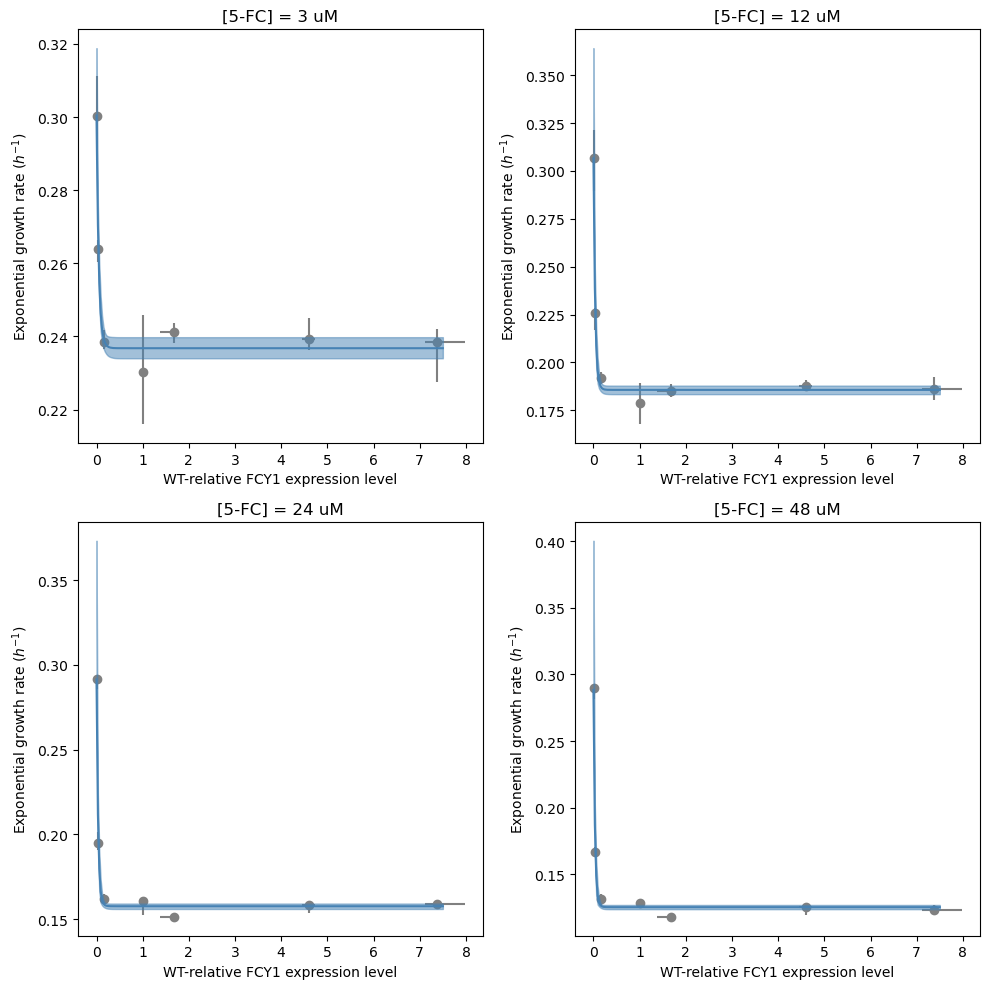

In [134]:
# Plotting the exponential decay fits for 5-FC
fig, axs = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)

fig_row = 0
fig_col = 0

for conc_5FC in np.sort(fit_exp_5FC['[5-FC] (uM)'].unique()):

    fit_subset = fit_exp_5FC[fit_exp_5FC['[5-FC] (uM)'] == conc_5FC].copy().reset_index(drop=True)

    fluo_err = np.array([fit_subset['Median_Median_rel_exp'] - fit_subset['Min_Median_rel_exp'],
                         fit_subset['Max_Median_rel_exp'] - fit_subset['Median_Median_rel_exp']])
    growth_err = np.array([fit_subset['Median_Max_log_rate'] - fit_subset['Min_Max_log_rate'],
                           fit_subset['Max_Max_log_rate'] - fit_subset['Median_Max_log_rate']])
    
    axs[fig_row, fig_col].scatter(fit_subset['Median_Median_rel_exp'], fit_subset['Median_Max_log_rate'], c='grey', zorder=0)
    axs[fig_row, fig_col].errorbar(fit_subset['Median_Median_rel_exp'], fit_subset['Median_Max_log_rate'], xerr=fluo_err, yerr=growth_err,
                                   fmt='none', zorder=0, ecolor='grey')
    axs[fig_row, fig_col].plot(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC[f'Median_decay_5FC_{int(conc_5FC)}'], c="steelblue", zorder=2)
    axs[fig_row, fig_col].fill_between(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC[f'decay_5FC_{int(conc_5FC)}_2_5'],
                                       curves_ci_5FC[f'decay_5FC_{int(conc_5FC)}_97_5'], alpha=0.5, color="steelblue", zorder=1)
    
    axs[fig_row, fig_col].set_xlabel(r"WT-relative FCY1 expression level")
    axs[fig_row, fig_col].set_ylabel(r"Exponential growth rate ($h^{-1}$)")
    axs[fig_row, fig_col].set_title(f'[5-FC] = {int(conc_5FC)} uM')

    if fig_col == 1:
        fig_row += 1
        fig_col = 0
    else:
        fig_col += 1

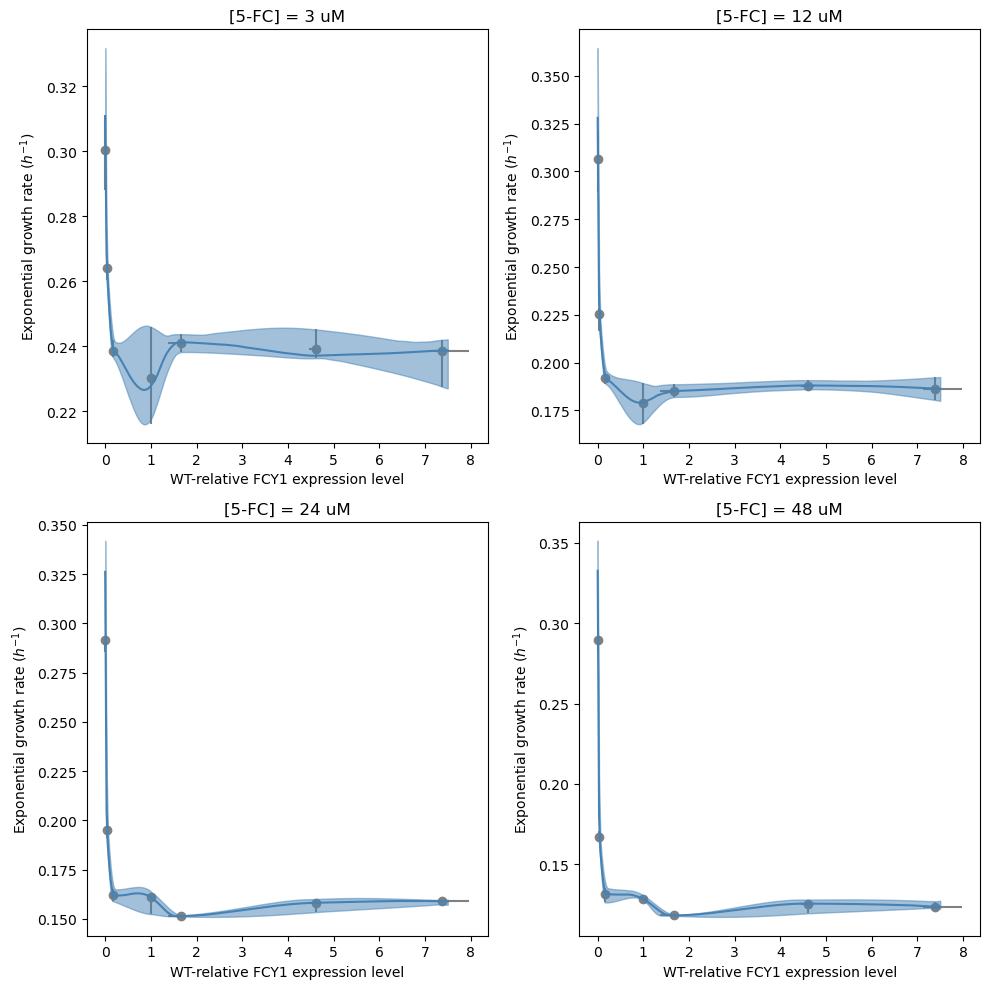

In [135]:
# Plotting the makima interpolation fits for 5-FC
fig, axs = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)

fig_row = 0
fig_col = 0

for conc_5FC in np.sort(fit_exp_5FC['[5-FC] (uM)'].unique()):

    fit_subset = fit_exp_5FC[fit_exp_5FC['[5-FC] (uM)'] == conc_5FC].copy().reset_index(drop=True)

    fluo_err = np.array([fit_subset['Median_Median_rel_exp'] - fit_subset['Min_Median_rel_exp'],
                         fit_subset['Max_Median_rel_exp'] - fit_subset['Median_Median_rel_exp']])
    growth_err = np.array([fit_subset['Median_Max_log_rate'] - fit_subset['Min_Max_log_rate'],
                           fit_subset['Max_Max_log_rate'] - fit_subset['Median_Max_log_rate']])
    
    axs[fig_row, fig_col].scatter(fit_subset['Median_Median_rel_exp'], fit_subset['Median_Max_log_rate'], c='grey', zorder=0)
    axs[fig_row, fig_col].errorbar(fit_subset['Median_Median_rel_exp'], fit_subset['Median_Max_log_rate'], xerr=fluo_err, yerr=growth_err,
                                   fmt='none', zorder=0, ecolor='grey')
    axs[fig_row, fig_col].plot(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC[f'Median_makima_5FC_{int(conc_5FC)}'], c="steelblue", zorder=2)
    axs[fig_row, fig_col].fill_between(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC[f'makima_5FC_{int(conc_5FC)}_2_5'],
                                       curves_ci_5FC[f'makima_5FC_{int(conc_5FC)}_97_5'], alpha=0.5, color="steelblue", zorder=1)
    
    axs[fig_row, fig_col].set_xlabel(r"WT-relative FCY1 expression level")
    axs[fig_row, fig_col].set_ylabel(r"Exponential growth rate ($h^{-1}$)")
    axs[fig_row, fig_col].set_title(f'[5-FC] = {int(conc_5FC)} uM')

    if fig_col == 1:
        fig_row += 1
        fig_col = 0
    else:
        fig_col += 1

The mAkima interpolation seems to work well!

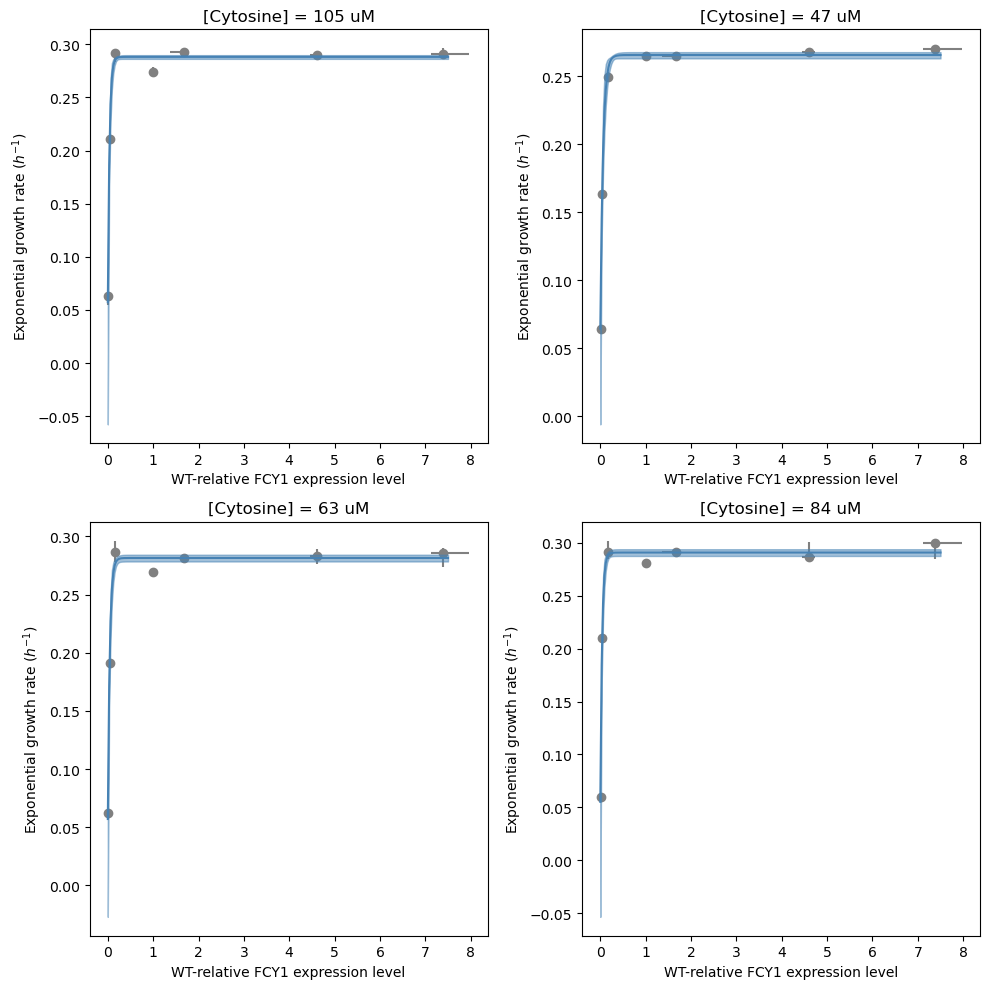

In [137]:
# Plotting the exponential decay fits for cytosine
fig, axs = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)

fig_row = 0
fig_col = 0

for conc_cyto in np.sort(fit_exp_cyto['[Cytosine] (uM)'].unique()):

    fit_subset = fit_exp_cyto[fit_exp_cyto['[Cytosine] (uM)'] == conc_cyto].copy().reset_index(drop=True)

    fluo_err = np.array([fit_subset['Median_Median_rel_exp'] - fit_subset['Min_Median_rel_exp'],
                         fit_subset['Max_Median_rel_exp'] - fit_subset['Median_Median_rel_exp']])
    growth_err = np.array([fit_subset['Median_Max_log_rate'] - fit_subset['Min_Max_log_rate'],
                           fit_subset['Max_Max_log_rate'] - fit_subset['Median_Max_log_rate']])

    if conc_cyto == '47,25':
        conc_cyto = '47'
    
    axs[fig_row, fig_col].scatter(fit_subset['Median_Median_rel_exp'], fit_subset['Median_Max_log_rate'], c='grey', zorder=0)
    axs[fig_row, fig_col].errorbar(fit_subset['Median_Median_rel_exp'], fit_subset['Median_Max_log_rate'], xerr=fluo_err, yerr=growth_err,
                                   fmt='none', zorder=0, ecolor='grey')
    axs[fig_row, fig_col].plot(curves_ci_cyto['Median_rel_exp'], curves_ci_cyto[f'Median_decay_cyto_{conc_cyto}'], c="steelblue", zorder=2)
    axs[fig_row, fig_col].fill_between(curves_ci_cyto['Median_rel_exp'], curves_ci_cyto[f'decay_cyto_{conc_cyto}_2_5'],
                                       curves_ci_cyto[f'decay_cyto_{conc_cyto}_97_5'], alpha=0.5, color="steelblue", zorder=1)
    
    axs[fig_row, fig_col].set_xlabel(r"WT-relative FCY1 expression level")
    axs[fig_row, fig_col].set_ylabel(r"Exponential growth rate ($h^{-1}$)")
    axs[fig_row, fig_col].set_title(f'[Cytosine] = {conc_cyto} uM')

    if fig_col == 1:
        fig_row += 1
        fig_col = 0
    else:
        fig_col += 1

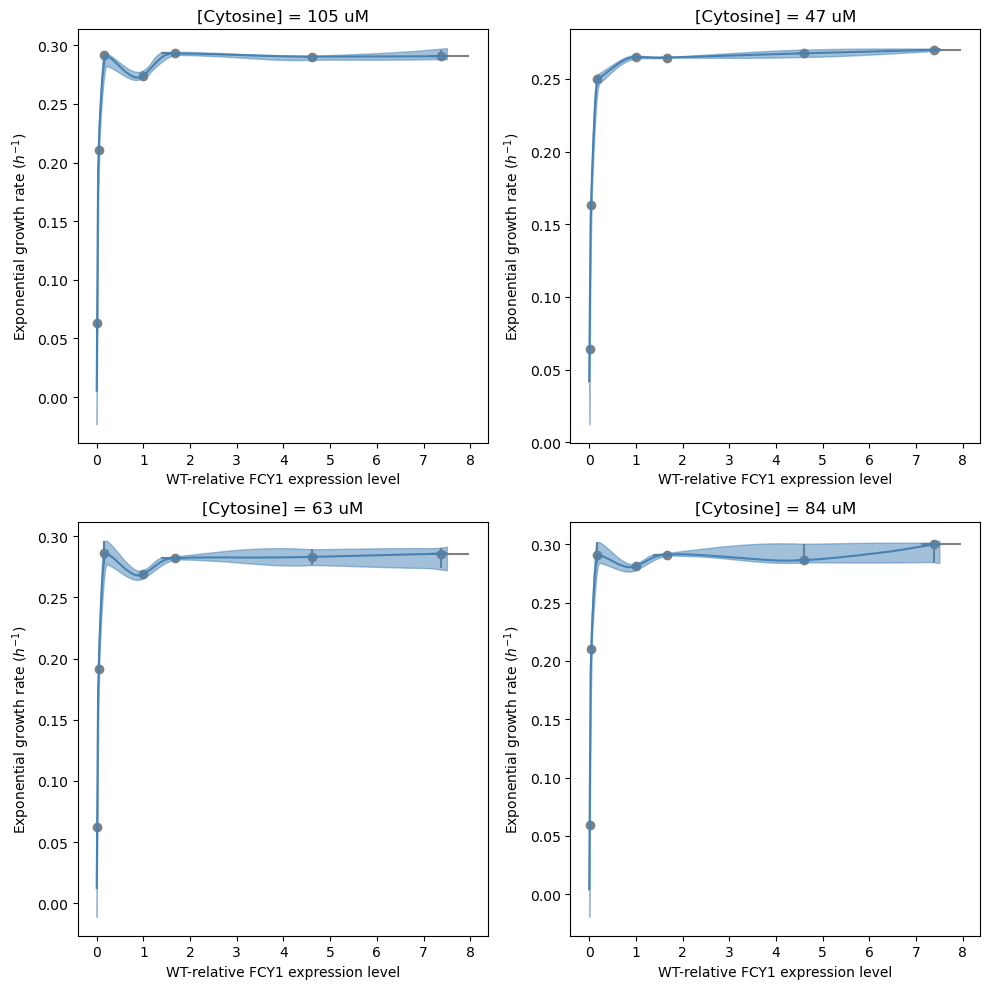

In [138]:
# Plotting the makima fits for cytosine
fig, axs = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)

fig_row = 0
fig_col = 0

for conc_cyto in np.sort(fit_exp_cyto['[Cytosine] (uM)'].unique()):

    fit_subset = fit_exp_cyto[fit_exp_cyto['[Cytosine] (uM)'] == conc_cyto].copy().reset_index(drop=True)

    fluo_err = np.array([fit_subset['Median_Median_rel_exp'] - fit_subset['Min_Median_rel_exp'],
                         fit_subset['Max_Median_rel_exp'] - fit_subset['Median_Median_rel_exp']])
    growth_err = np.array([fit_subset['Median_Max_log_rate'] - fit_subset['Min_Max_log_rate'],
                           fit_subset['Max_Max_log_rate'] - fit_subset['Median_Max_log_rate']])

    if conc_cyto == '47,25':
        conc_cyto = '47'
    
    axs[fig_row, fig_col].scatter(fit_subset['Median_Median_rel_exp'], fit_subset['Median_Max_log_rate'], c='grey', zorder=0)
    axs[fig_row, fig_col].errorbar(fit_subset['Median_Median_rel_exp'], fit_subset['Median_Max_log_rate'], xerr=fluo_err, yerr=growth_err,
                                   fmt='none', zorder=0, ecolor='grey')
    axs[fig_row, fig_col].plot(curves_ci_cyto['Median_rel_exp'], curves_ci_cyto[f'Median_makima_cyto_{conc_cyto}'], c="steelblue", zorder=2)
    axs[fig_row, fig_col].fill_between(curves_ci_cyto['Median_rel_exp'], curves_ci_cyto[f'makima_cyto_{conc_cyto}_2_5'],
                                       curves_ci_cyto[f'makima_cyto_{conc_cyto}_97_5'], alpha=0.5, color="steelblue", zorder=1)
    
    axs[fig_row, fig_col].set_xlabel(r"WT-relative FCY1 expression level")
    axs[fig_row, fig_col].set_ylabel(r"Exponential growth rate ($h^{-1}$)")
    axs[fig_row, fig_col].set_title(f'[Cytosine] = {conc_cyto} uM')

    if fig_col == 1:
        fig_row += 1
        fig_col = 0
    else:
        fig_col += 1

#### Looked at the inferred growth rates of mutants

In [140]:
fit_mutants_pred

,Genotype,Median_decay_5FC_12,decay_5FC_12_2_5,decay_5FC_12_97_5,Median_makima_5FC_12,makima_5FC_12_2_5,makima_5FC_12_97_5
0,D-106_1nt_Gto-,0.185666,0.183432,0.187903,0.180073,0.170159,0.188903
1,D-107_1nt_Cto-,0.185666,0.183432,0.187903,0.180655,0.170751,0.188744
2,D-108_1nt_Gto-,0.185666,0.183432,0.187903,0.179955,0.169843,0.188975
3,D-109_1nt_Ato-,0.185666,0.183432,0.187903,0.179405,0.168532,0.189338
4,D-112_1nt_Tto-,0.185666,0.183432,0.187903,0.180396,0.170922,0.188738
...,...,...,...,...,...,...,...
1093,S-98_1nt_TtoC,0.185666,0.183432,0.187903,0.179715,0.169315,0.189070
1094,S-98_1nt_TtoG,0.185666,0.183432,0.187903,0.179783,0.169817,0.188952
1095,S-99_1nt_TtoA,0.185666,0.183432,0.187903,0.179942,0.170123,0.188891
1096,S-99_1nt_TtoC,0.185666,0.183432,0.187903,0.179781,0.169204,0.189204


In [141]:
# Combining bootstrapped mutant fitness with mutant information
fit_predict_muts = pd.merge(fit_mutants_pred, sort_all_reps[['Genotype', 'Mutation type', 'Position', 'In_F3F4']].copy().drop_duplicates(),
                            on='Genotype', how='left')
fit_predict_muts['FCY1_position'] = fit_predict_muts['Position'] - 205 + 1*(fit_predict_muts['Mutation type'] == 'Insertion')

fit_predict_F3F4 = fit_predict_muts[fit_predict_muts['In_F3F4']].copy().reset_index(drop=True)

Text(0.5, 1.0, 'Makima interpolation')

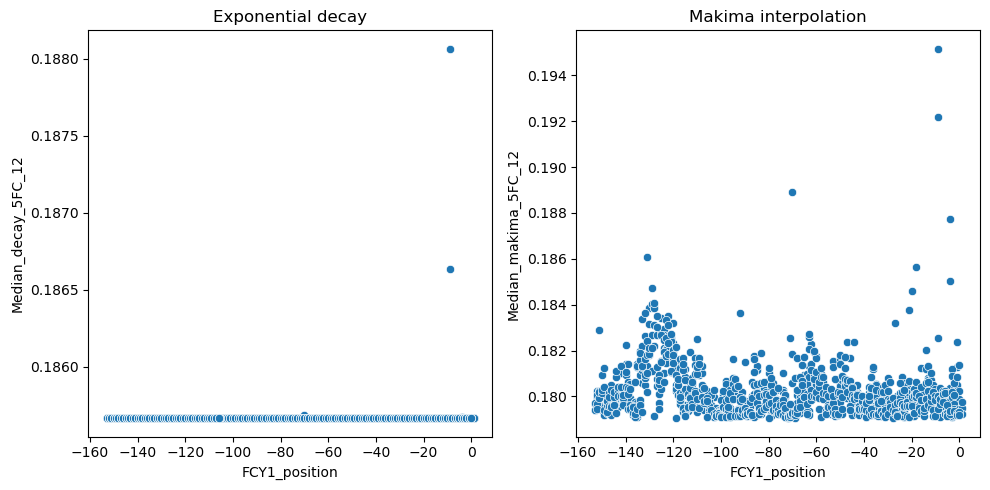

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

sns.scatterplot(data=fit_predict_F3F4, x='FCY1_position', y='Median_decay_5FC_12', ax=axs[0])
axs[0].set_title('Exponential decay')

sns.scatterplot(data=fit_predict_F3F4, x='FCY1_position', y='Median_makima_5FC_12', ax=axs[1])
axs[1].set_title('Makima interpolation')

Text(0.5, 1.0, 'Makima interpolation')

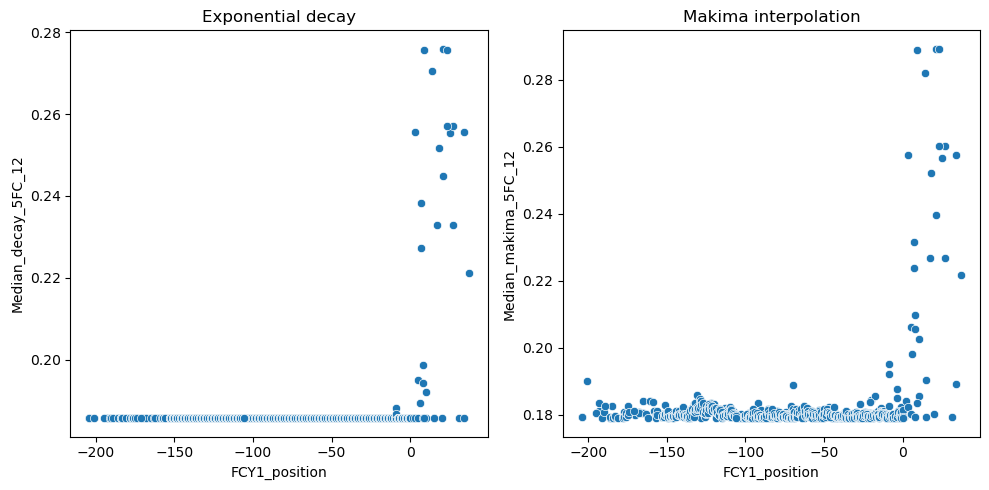

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

sns.scatterplot(data=fit_predict_muts, x='FCY1_position', y='Median_decay_5FC_12', ax=axs[0])
axs[0].set_title('Exponential decay')

sns.scatterplot(data=fit_predict_muts, x='FCY1_position', y='Median_makima_5FC_12', ax=axs[1])
axs[1].set_title('Makima interpolation')

Overall, these results seem to support very well the absence of significant fitness effects in our 5-FC competition experiment. Let's convert growth rates into selection coefficients before analyzing it any further.

#### Converting growth rates (and exp-fitness curves) into selection coefficients

In [146]:
# First, interpolating fitness at Rel_exp=1 to convert into selection coefficients
wt_decay = np.interp(1, eval_fit_vals, curves_ci_5FC['Median_decay_5FC_12'])
wt_makima = np.interp(1, eval_fit_vals, curves_ci_5FC['Median_makima_5FC_12'])

# Getting upper and lower bounds on wt s 
lower_decay = ((np.interp(1, eval_fit_vals, curves_ci_5FC['decay_5FC_12_2_5']) - wt_decay) / wt_decay) * np.log(2)
upper_decay = ((np.interp(1, eval_fit_vals, curves_ci_5FC['decay_5FC_12_97_5']) - wt_decay) / wt_decay) * np.log(2)
lower_makima = ((np.interp(1, eval_fit_vals, curves_ci_5FC['makima_5FC_12_2_5']) - wt_makima) / wt_makima) * np.log(2)
upper_makima = ((np.interp(1, eval_fit_vals, curves_ci_5FC['makima_5FC_12_97_5']) - wt_makima) / wt_makima) * np.log(2)

In [147]:
# Converting all growth rates into selection ceofficients
s_predict = fit_predict_muts[['Genotype', 'Median_decay_5FC_12', 'decay_5FC_12_2_5',
                              'decay_5FC_12_97_5', 'Median_makima_5FC_12', 'makima_5FC_12_2_5',
                              'makima_5FC_12_97_5','Mutation type', 'Position', 'In_F3F4', 'FCY1_position']].copy()

s_predict[['Median_decay_5FC_12', 'decay_5FC_12_2_5', 'decay_5FC_12_97_5']] = ((s_predict[['Median_decay_5FC_12', 'decay_5FC_12_2_5', 'decay_5FC_12_97_5']] - wt_decay) / wt_decay) * np.log(2)
s_predict[['Median_makima_5FC_12', 'makima_5FC_12_2_5', 'makima_5FC_12_97_5']] = ((s_predict[['Median_makima_5FC_12', 'makima_5FC_12_2_5', 'makima_5FC_12_97_5']] - wt_makima) / wt_makima) * np.log(2)

In [148]:
# Doing the same for the fitted curves
s_curve = curves_ci_5FC[['Median_rel_exp', 'Median_decay_5FC_12', 'decay_5FC_12_2_5', 'decay_5FC_12_97_5',
                         'Median_makima_5FC_12', 'makima_5FC_12_2_5', 'makima_5FC_12_97_5']].copy()

s_curve[['Median_decay_5FC_12', 'decay_5FC_12_2_5', 'decay_5FC_12_97_5']] = ((s_curve[['Median_decay_5FC_12', 'decay_5FC_12_2_5', 'decay_5FC_12_97_5']] - wt_decay) / wt_decay) * np.log(2)
s_curve[['Median_makima_5FC_12', 'makima_5FC_12_2_5', 'makima_5FC_12_97_5']] = ((s_curve[['Median_makima_5FC_12', 'makima_5FC_12_2_5', 'makima_5FC_12_97_5']] - wt_makima) / wt_makima) * np.log(2)

# And for the experimental measurements (so that they can be put on plots showing the curves)
proms_s_decay = fit_exp_5FC[fit_exp_5FC['[5-FC] (uM)'] == 12].copy()
proms_s_decay[['Median_Max_log_rate', 'Min_Max_log_rate', 'Max_Max_log_rate']] = ((proms_s_decay[['Median_Max_log_rate', 'Min_Max_log_rate', 'Max_Max_log_rate']] - wt_decay) / wt_decay) * np.log(2)

proms_s_makima = fit_exp_5FC[fit_exp_5FC['[5-FC] (uM)'] == 12].copy()
proms_s_makima[['Median_Max_log_rate', 'Min_Max_log_rate', 'Max_Max_log_rate']] = ((proms_s_makima[['Median_Max_log_rate', 'Min_Max_log_rate', 'Max_Max_log_rate']] - wt_makima) / wt_makima) * np.log(2)

In [149]:
# Computing the corresponding diffs (for error bars on experimental fitness measurements)
s_decay_err = np.array([proms_s_decay['Median_Max_log_rate'] - proms_s_decay['Min_Max_log_rate'],
                        proms_s_decay['Max_Max_log_rate'] - proms_s_decay['Median_Max_log_rate']])

s_makima_err = np.array([proms_s_makima['Median_Max_log_rate'] - proms_s_makima['Min_Max_log_rate'],
                         proms_s_makima['Max_Max_log_rate'] - proms_s_makima['Median_Max_log_rate']])

Text(0.5, 1.0, 'Makima interpolation')

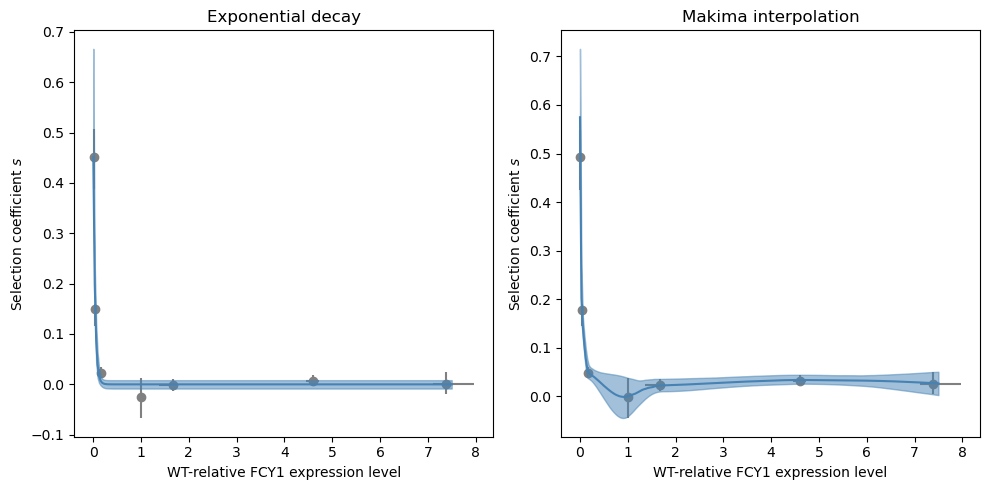

In [150]:
# Plotting the curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# For exp decay
axs[0].scatter(proms_s_decay['Median_Median_rel_exp'], proms_s_decay['Median_Max_log_rate'], c='grey', zorder=0)
axs[0].errorbar(proms_s_decay['Median_Median_rel_exp'], proms_s_decay['Median_Max_log_rate'], xerr=fluo_err, yerr=s_decay_err,
                  fmt='none', zorder=0, ecolor='grey')
axs[0].plot(s_curve['Median_rel_exp'], s_curve['Median_decay_5FC_12'], c="steelblue", zorder=2)
axs[0].fill_between(s_curve['Median_rel_exp'], s_curve['decay_5FC_12_2_5'], s_curve['decay_5FC_12_97_5'], alpha=0.5, color="steelblue",
                      zorder=1)
axs[0].set_xlabel(r"WT-relative FCY1 expression level")
axs[0].set_ylabel(r"Selection coefficient $s$")
axs[0].set_title('Exponential decay')

# For makima interpolation
axs[1].scatter(proms_s_makima['Median_Median_rel_exp'], proms_s_makima['Median_Max_log_rate'], c='grey', zorder=0)
axs[1].errorbar(proms_s_makima['Median_Median_rel_exp'], proms_s_makima['Median_Max_log_rate'], xerr=fluo_err, yerr=s_makima_err,
                  fmt='none', zorder=0, ecolor='grey')
axs[1].plot(s_curve['Median_rel_exp'], s_curve['Median_makima_5FC_12'], c="steelblue", zorder=2)
axs[1].fill_between(s_curve['Median_rel_exp'], s_curve['makima_5FC_12_2_5'], s_curve['makima_5FC_12_97_5'], alpha=0.5, color="steelblue",
                    zorder=1)
axs[1].set_xlabel(r"WT-relative FCY1 expression level")
axs[1].set_ylabel(r"Selection coefficient $s$")
axs[1].set_title('Makima interpolation')

#### Assessing the distribution of (inferred) fitness effects

First, the plotting inferred selection coefficients **with error bars** according to position along the F3-F4 region.

Text(0.5, 1.0, 's from makima interpolation')

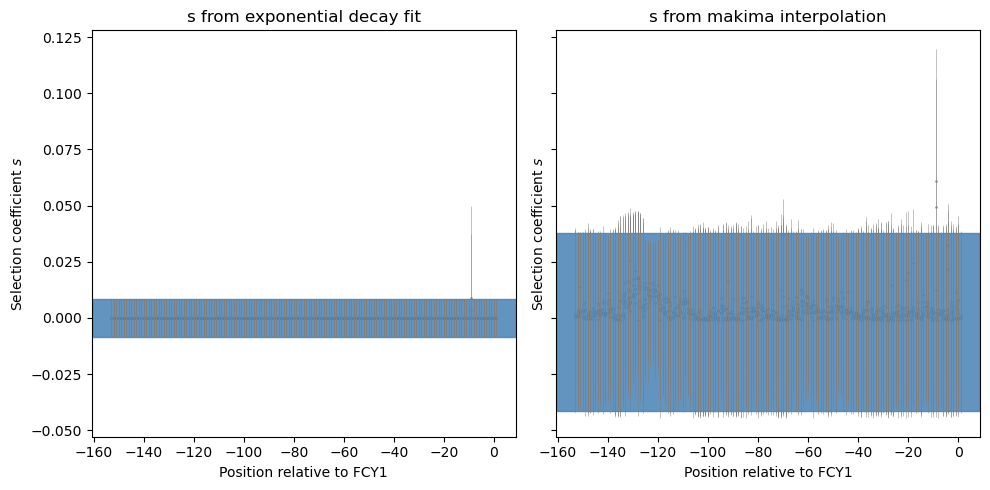

In [153]:
s_predict_F3F4 = s_predict[s_predict['In_F3F4']].copy().reset_index(drop=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, sharex=True, sharey=True)

# 1) Exponential decay fit function
mut_err_decay = np.array([s_predict_F3F4['Median_decay_5FC_12'] - s_predict_F3F4['decay_5FC_12_2_5'],
                       s_predict_F3F4['decay_5FC_12_97_5'] - s_predict_F3F4['Median_decay_5FC_12']])

axs[0].scatter(s_predict_F3F4['FCY1_position'], s_predict_F3F4['Median_decay_5FC_12'], c='grey', s=0.85, alpha=0.75)
axs[0].errorbar(s_predict_F3F4['FCY1_position'], s_predict_F3F4['Median_decay_5FC_12'],
                yerr=mut_err_decay, c='grey', linewidth=0.45, alpha=0.75, fmt='none')

axs[0].axhspan(ymin=lower_decay, ymax=upper_decay, color='steelblue', alpha=0.85)

axs[0].set_xlabel('Position relative to FCY1')
axs[0].set_ylabel(r"Selection coefficient $s$")
axs[0].set_title(f's from exponential decay fit')

# 2) Makima interpolation fit function
mut_err_makima = np.array([s_predict_F3F4['Median_makima_5FC_12'] - s_predict_F3F4['makima_5FC_12_2_5'],
                       s_predict_F3F4['makima_5FC_12_97_5'] - s_predict_F3F4['Median_makima_5FC_12']])

axs[1].scatter(s_predict_F3F4['FCY1_position'], s_predict_F3F4['Median_makima_5FC_12'], c='grey', s=0.85, alpha=0.75)
axs[1].errorbar(s_predict_F3F4['FCY1_position'], s_predict_F3F4['Median_makima_5FC_12'],
                yerr=mut_err_makima, c='grey', linewidth=0.45, alpha=0.75, fmt='none')

axs[1].axhspan(ymin=lower_makima, ymax=upper_makima, color='steelblue', alpha=0.85)

axs[1].set_xlabel('Position relative to FCY1')
axs[1].set_ylabel(r"Selection coefficient $s$")
axs[1].set_title(f's from makima interpolation')

It seems clear that there are very few "significant" fitness effects. Even under the "worst case scenario" (modified Akima interpolation), the only selection coefficients which are significantly different from 0 are very close to or below the detection limit of our assay.

#### How do these fitness estimates correlate with measurements from the 5-FC screen?

In [156]:
# Importing and preparing the measurements 
s_screen = pd.read_csv('Supp_data/s_300_5FC_no_out.csv')

s_screen = s_screen[['Genotype', 'Position', 'Mutation type', 'FCY1_position',
                     'In F3F4', 'Median_s_ignored', 'Min_s_ignored', 'Max_s_ignored']].copy().drop_duplicates()
s_screen = s_screen.rename(columns={'In F3F4': 'In_F3F4'})

In [157]:
# Merging the data
s_merged = pd.merge(s_screen, s_predict, on=['Genotype', 'Mutation type', 'Position', 'In_F3F4', 'FCY1_position'], how='outer')

Text(0.5, 1.0, 'Makima interpolation')

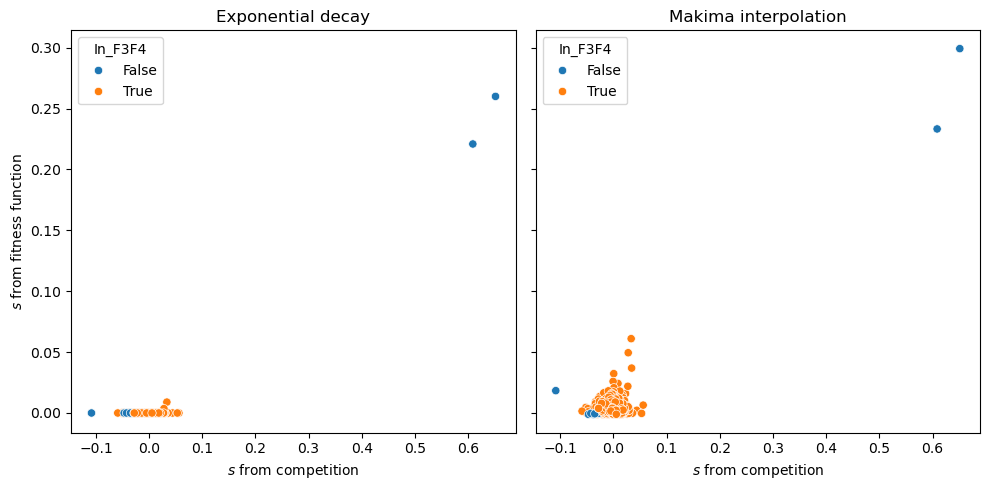

In [158]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, sharex=True, sharey=True)

sns.scatterplot(data=s_merged, x='Median_s_ignored', y='Median_decay_5FC_12', hue='In_F3F4', ax=axs[0])
axs[0].set_ylabel(r"$s$ from fitness function")
axs[0].set_xlabel(r"$s$ from competition")
axs[0].set_title('Exponential decay')
sns.scatterplot(data=s_merged, x='Median_s_ignored', y='Median_makima_5FC_12', hue='In_F3F4', ax=axs[1])
axs[1].set_ylabel(r"$s$ from fitness function")
axs[1].set_xlabel(r"$s$ from competition")
axs[1].set_title('Makima interpolation')

Text(0.5, 1.0, 'Makima interpolation')

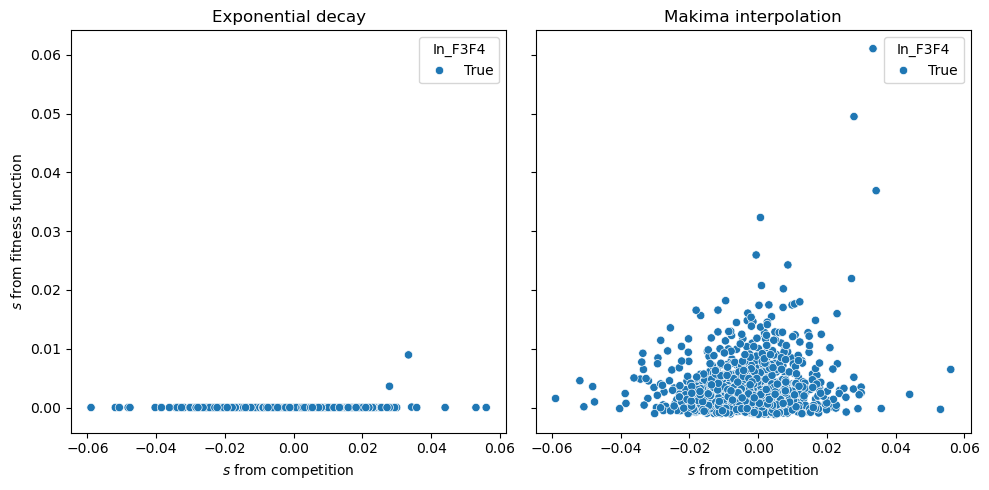

In [159]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, sharex=True, sharey=True)

sns.scatterplot(data=s_merged[s_merged['In_F3F4']], x='Median_s_ignored', y='Median_decay_5FC_12', hue='In_F3F4', ax=axs[0])
axs[0].set_ylabel(r"$s$ from fitness function")
axs[0].set_xlabel(r"$s$ from competition")
axs[0].set_title('Exponential decay')
sns.scatterplot(data=s_merged[s_merged['In_F3F4']], x='Median_s_ignored', y='Median_makima_5FC_12', hue='In_F3F4', ax=axs[1])
axs[1].set_ylabel(r"$s$ from fitness function")
axs[1].set_xlabel(r"$s$ from competition")
axs[1].set_title('Makima interpolation')

There is no obvious relationship which would establish than one model better captures the 'true' fitness function. Overall, this suggests that most variation in s in the bulk competition assay is noise, as we suspected.

## Computing selection coefficients of validation mutants in 12 uM 5-FC

### Importing growth data (in 5-FC and SC)

In [163]:
OD_5FC = pd.read_csv("Growth_validation/5FC_plate_25-05-09_AKD.csv", encoding='unicode_escape')

temp_5FC = OD_5FC.iloc[0, 1:].copy()  # Separating the temperature timeseries, in case we want to use it later
OD_5FC = OD_5FC.iloc[1:, :].copy()
OD_5FC = OD_5FC.dropna(subset=['Unnamed: 0']).reset_index(drop=True).copy()
OD_5FC = OD_5FC.rename(columns={'Unnamed: 0': 'Well'})

# Reformatting the well column
OD_5FC['Well'] = OD_5FC['Well'].apply(lambda x: x[0]+'0'+x[1] if len(x)==2 else x)

OD_5FC.to_csv("Growth_validation/5FC_plate_25-05-09_modified.csv")

In [164]:
OD_SC = pd.read_csv("Growth_validation/SC_plate_25-05-09_AKD.csv", encoding='unicode_escape')

temp_SC = OD_SC.iloc[0, 1:].copy()  # Separating the temperature timeseries, in case we want to use it later
OD_SC = OD_SC.iloc[1:, :].copy()
OD_SC = OD_SC.dropna(subset=['Unnamed: 0']).reset_index(drop=True).copy()
OD_SC = OD_SC.rename(columns={'Unnamed: 0': 'Well'})

# Reformatting the well column
OD_SC['Well'] = OD_SC['Well'].apply(lambda x: x[0]+'0'+x[1] if len(x)==2 else x)

OD_SC.to_csv("Growth_validation/SC_plate_25-05-09_modified.csv")

In [165]:
# Obtaining the processed df from each TECAN output file
merged_5FC = merged_growth_series("Growth_validation/5FC_plate_25-05-09_modified.csv",
                                  "Growth_validation/well_mapping_df.csv")

merged_SC = merged_growth_series("Growth_validation/SC_plate_25-05-09_modified.csv",
                                 "Growth_validation/well_mapping_df.csv")

### Computing (max log) growth rates

In [167]:
# Preparing dataframes to store the rates
rates_5FC = merged_5FC[['Well', 'Mutant_id']].copy().drop_duplicates()
rates_SC = merged_SC[['Well', 'Mutant_id']].copy().drop_duplicates()

In [168]:
rates_5FC['Max_log_rate'] = rates_5FC['Well'].apply(lambda x: get_max_log_deriv(merged_5FC, x, 'Well', 'OD', 4, 0.25)[0])
rates_SC['Max_log_rate'] = rates_SC['Well'].apply(lambda x: get_max_log_deriv(merged_SC, x, 'Well', 'OD', 4, 0.25)[0])

###  Adding mutant information

In [170]:
mut_mapping = pd.read_csv("Growth_validation/mutant_mapping_df.csv")

# The "Mutant_desc" column first needs to be reformatted
not_single_nt = mut_mapping.iloc[29:, :].copy()
only_single_nt = mut_mapping.iloc[:29, :].copy()

only_single_nt['Mutant_desc'] = only_single_nt['Mutant_desc'].apply(lambda x: x.split(' ')[0])

# Recombining the two halves
genotypes_mapping = pd.concat([only_single_nt, not_single_nt]).reset_index(drop=True)

# Removing NaN from T_insert
genotypes_mapping['T_insert'] = genotypes_mapping['T_insert'].fillna('False')

In [171]:
# Combining with the growth rates
rates_5FC = pd.merge(rates_5FC, genotypes_mapping[['Mutant_id', 'T_insert', 'Mutant_desc']].copy(), on='Mutant_id', how='left')
rates_SC = pd.merge(rates_SC, genotypes_mapping[['Mutant_id', 'T_insert', 'Mutant_desc']].copy(), on='Mutant_id', how='left')

### Assessing whether there are outlier wells

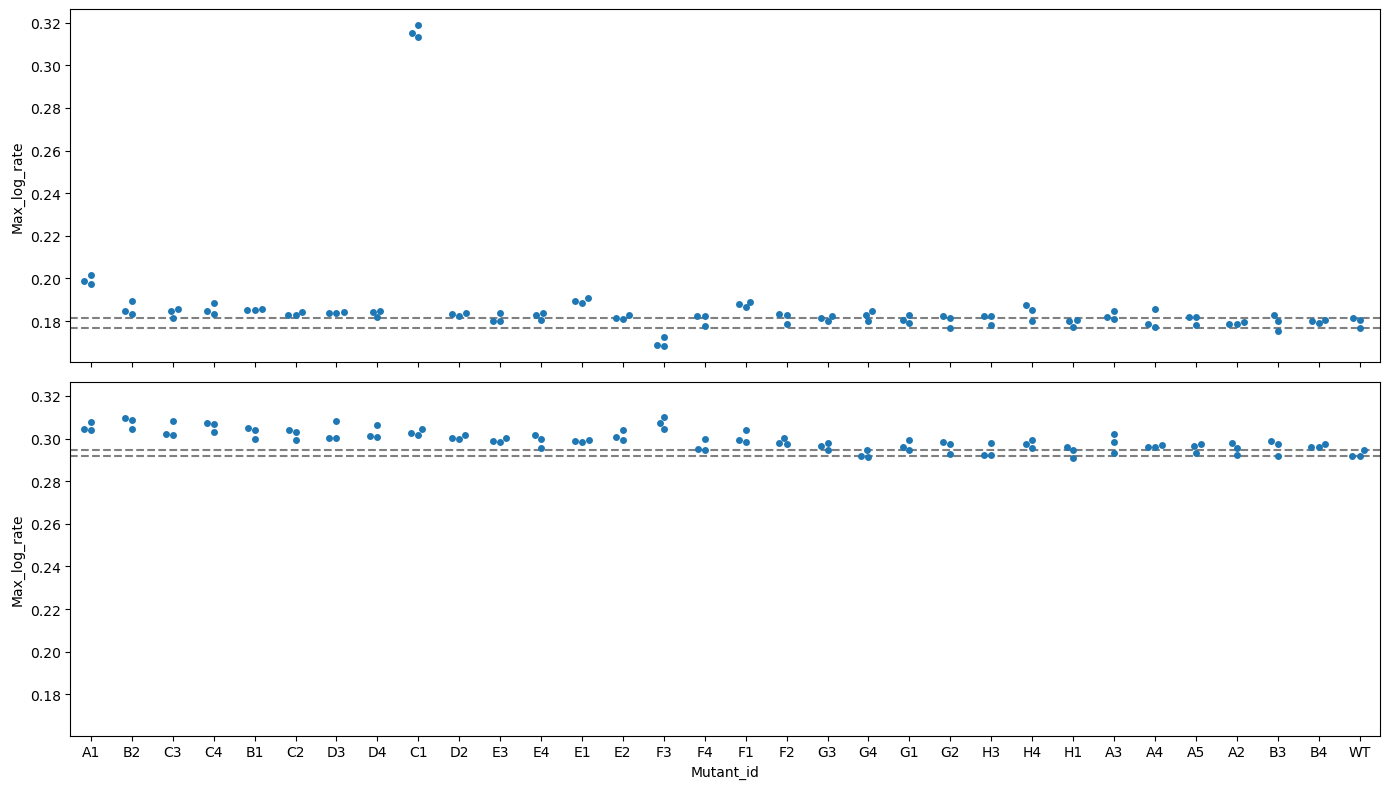

In [173]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True, sharey=True, tight_layout=True)

sns.swarmplot(data=rates_5FC, x='Mutant_id', y='Max_log_rate', ax=axs[0])
# Adding dashed lines for the WT measurements
min_WT_5FC = np.min(rates_5FC[rates_5FC['Mutant_id'] == 'WT']['Max_log_rate'])
max_WT_5FC = np.max(rates_5FC[rates_5FC['Mutant_id'] == 'WT']['Max_log_rate'])
axs[0].axhline(y=min_WT_5FC, c='grey', linestyle='--')
axs[0].axhline(y=max_WT_5FC, c='grey', linestyle='--')


sns.swarmplot(data=rates_SC, x='Mutant_id', y='Max_log_rate', ax=axs[1])
# Adding dashed lines for the WT measurements
min_WT_SC = np.min(rates_SC[rates_SC['Mutant_id'] == 'WT']['Max_log_rate'])
max_WT_SC = np.max(rates_SC[rates_SC['Mutant_id'] == 'WT']['Max_log_rate'])
axs[1].axhline(y=min_WT_SC, c='grey', linestyle='--')
axs[1].axhline(y=max_WT_SC, c='grey', linestyle='--')

The clear growth defect of F3 in 5-FC is weird, since there is no evidence that changes in FCY1 expression from WT level can be deleterious. It is also associated with the highest growth rate in SC. Since this mutant is weird, it will be removed. 

### Conversion of growth rates in selection coefficients

In [176]:
med_WT_5FC = np.median(rates_5FC[rates_5FC['Mutant_id'] == 'WT']['Max_log_rate'])
med_WT_SC = np.median(rates_SC[rates_SC['Mutant_id'] == 'WT']['Max_log_rate'])

rates_5FC['s_log'] = ((rates_5FC['Max_log_rate'] - med_WT_5FC) / med_WT_5FC) * np.log(2)
rates_SC['s_log'] = ((rates_SC['Max_log_rate'] - med_WT_SC) / med_WT_SC) * np.log(2)

#### Are selection coefficients correlated with estimated expression levels?

In [178]:
# Aggregating selection coefficients
med_s_5FC = rates_5FC[['Mutant_id', 'Mutant_desc',
                       'T_insert', 'Max_log_rate', 's_log']].copy().groupby(by=['Mutant_id', 'Mutant_desc', 'T_insert'], as_index=False).median()

# Adding min and max
min_s_log = rates_5FC[['Mutant_id', 'Mutant_desc',
                       'T_insert', 'Max_log_rate', 's_log']].copy().groupby(by=['Mutant_id', 'Mutant_desc', 'T_insert'], as_index=False).min()
min_s_log = min_s_log.rename(columns={'s_log': 'Min_s_log'})
min_s_log = min_s_log.rename(columns={'Max_log_rate': 'Min_Max_log_rate'})

max_s_log = rates_5FC[['Mutant_id', 'Mutant_desc',
                       'T_insert', 'Max_log_rate', 's_log']].copy().groupby(by=['Mutant_id', 'Mutant_desc', 'T_insert'], as_index=False).max()
max_s_log = max_s_log.rename(columns={'s_log': 'Max_s_log'})
max_s_log = max_s_log.rename(columns={'Max_log_rate': 'Max_Max_log_rate'})

med_s_5FC = pd.merge(med_s_5FC, min_s_log, on=['Mutant_id', 'Mutant_desc', 'T_insert'])
med_s_5FC = pd.merge(med_s_5FC, max_s_log, on=['Mutant_id', 'Mutant_desc', 'T_insert'])

In [179]:
# Merging with estimated expression levels
med_s_5FC = med_s_5FC.rename(columns={'Mutant_desc': 'Genotype',
                                     'T_insert': 'T_insertion'})

fit_exp_comp = pd.merge(med_s_5FC, sort_comp[['Genotype', 'T_insertion', 'Relative_median_exp',
                                              'Max_rel_exp', 'Min_rel_exp', 'Mutation type',
                                              'In_F3F4', 'FCY1_position']],
                        on=['Genotype'], how='right', suffixes=('_FCY1', '_42-GFP'))

# We lack growth data for one mutant with expression data
fit_exp_comp = fit_exp_comp.dropna(subset='Mutant_id').reset_index(drop=True)

<Axes: xlabel='Relative_median_exp', ylabel='s_log'>

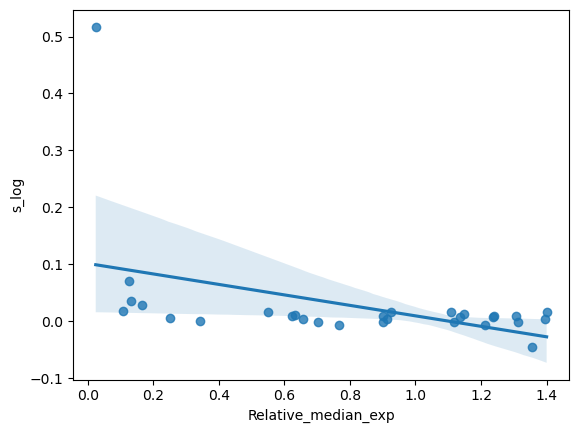

In [180]:
# Correlation for all mutants
sns.regplot(data=fit_exp_comp, x='Relative_median_exp', y='s_log')

<Axes: xlabel='Relative_median_exp', ylabel='s_log'>

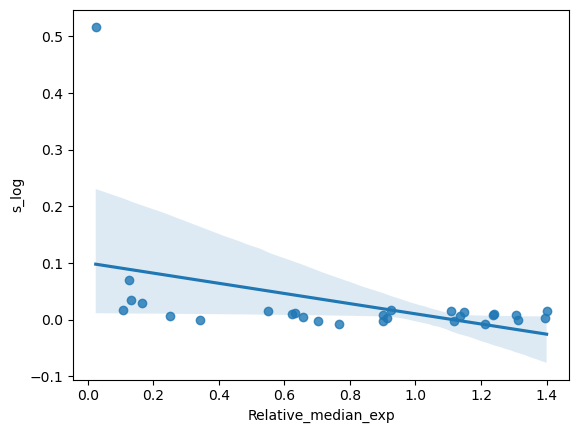

In [181]:
# Removing F3
sns.regplot(data=fit_exp_comp[fit_exp_comp['Mutant_id'] != 'F3'], x='Relative_median_exp', y='s_log')

<Axes: xlabel='Relative_median_exp', ylabel='s_log'>

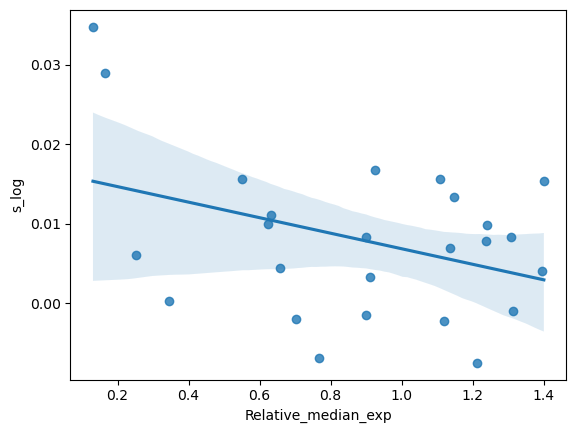

In [182]:
# Keeping only the F3-F4 mutants
fit_comp_F3F4 = fit_exp_comp[fit_exp_comp['In_F3F4']].copy().reset_index(drop=True)

sns.regplot(data=fit_comp_F3F4[fit_comp_F3F4['Mutant_id'] != 'F3'], x='Relative_median_exp', y='s_log')

There is no evidence for strong fitness effects which we should have detected in the bulk competition!

#### Correlation with s coefficients inferred from expression-growth relationships

In [185]:
s_valid_comp = pd.merge(fit_comp_F3F4, s_predict, on=['Genotype', 'In_F3F4', 'FCY1_position', 'Mutation type'],
                       how='left')

Text(0.5, 1.0, 'Makima interpolation')

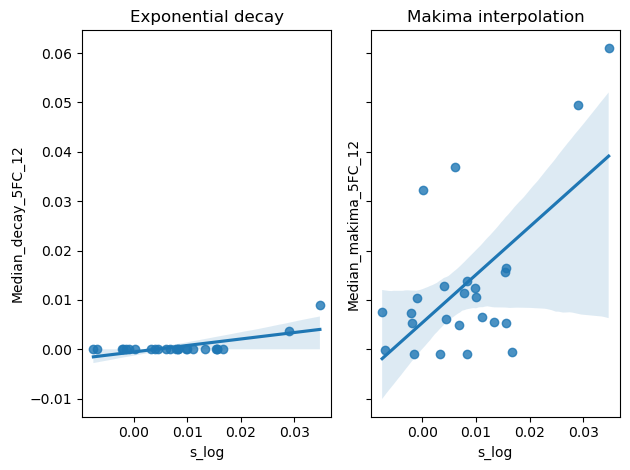

In [186]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True)

sns.regplot(data=s_valid_comp[s_valid_comp['Mutant_id'] != 'F3'], x='s_log', y='Median_decay_5FC_12', ax=axs[0])
axs[0].set_title('Exponential decay')

sns.regplot(data=s_valid_comp[s_valid_comp['Mutant_id'] != 'F3'], x='s_log', y='Median_makima_5FC_12', ax=axs[1])
axs[1].set_title('Makima interpolation')

What do the same plots look like using the s coefficients from the bulk competition?

In [188]:
s_valid_bulk = pd.merge(fit_comp_F3F4, s_screen, on=['Genotype', 'In_F3F4', 'FCY1_position', 'Mutation type'],
                        how='left')

<Axes: xlabel='s_log', ylabel='Median_s_ignored'>

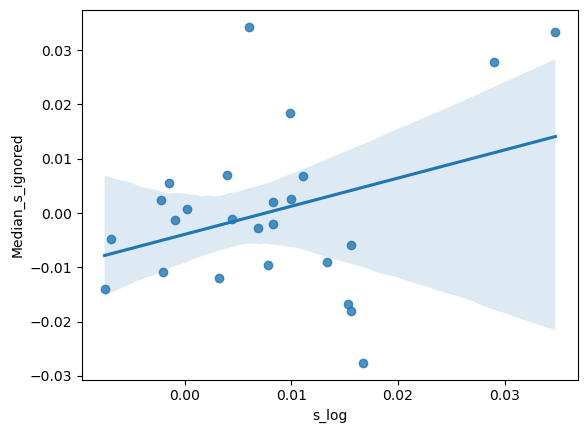

In [189]:
sns.regplot(data=s_valid_bulk[s_valid_bulk['Mutant_id'] != 'F3'], x='s_log', y='Median_s_ignored')

There is a nice agreement for the top two hits, even though nothing was significant using the t-test on bulk competition s coefficients.
It seems like this is due to low power when using only 4 samples to make the test... Still, it is clear that no selection coefficient > 0.05 was expected in screen.

### Exporting data to be reused for Fig 6

In [192]:
fit_exp_5FC.to_csv("Supp_data/fit_promoters_5FC.csv", index=False)
med_s_5FC.to_csv("Supp_data/growth_5FC_validation.csv", index=False)
fit_exp_comp.to_csv("Supp_data/growth_exp_val_mutants.csv", index=False)
s_curve.to_csv("Supp_data/s_curve_5FC.csv", index=False)

In [193]:
fit_exp_5FC = pd.read_csv("Supp_data/fit_promoters_5FC.csv")
med_s_5FC = pd.read_csv("Supp_data/growth_5FC_validation.csv")
fit_exp_comp = pd.read_csv("Supp_data/growth_exp_val_mutants.csv")
s_curve = pd.read_csv("Supp_data/s_curve_5FC.csv")

## Supplementary figures

### S19 Fig: Fitness functions in varying concentrations of 5-FC and cytosine

In [196]:
from matplotlib import cm
import matplotlib.colors as colors
plt.rcParams['savefig.dpi'] = 600
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 11

In [197]:
# Color palette for the constitutive promoters
dark2_palette = {'Wild-type': cm.Dark2.colors[1], 'pADH1': cm.Dark2.colors[2], 'pCUP1': cm.Dark2.colors[3],
                 'pCYC1': cm.Dark2.colors[4], 'pGAL-L': cm.Dark2.colors[5], 'pTDH3': cm.Dark2.colors[6],
                 'pTEF1': cm.Dark2.colors[7]}

fc_palette = sns.color_palette('rocket', 4)
cyto_palette = sns.color_palette('mako', 4)

# Modifying the cytosine conc in the df of growth rates
fit_exp_cyto['[Cytosine] (uM)'] = fit_exp_cyto['[Cytosine] (uM)'].apply(lambda x: 47 if x=='47,25' else int(x))

# Sorting both dfs
fit_exp_5FC = fit_exp_5FC.sort_values(by='Median_Median_rel_exp')
fit_exp_cyto = fit_exp_cyto.sort_values(by='Median_Median_rel_exp')

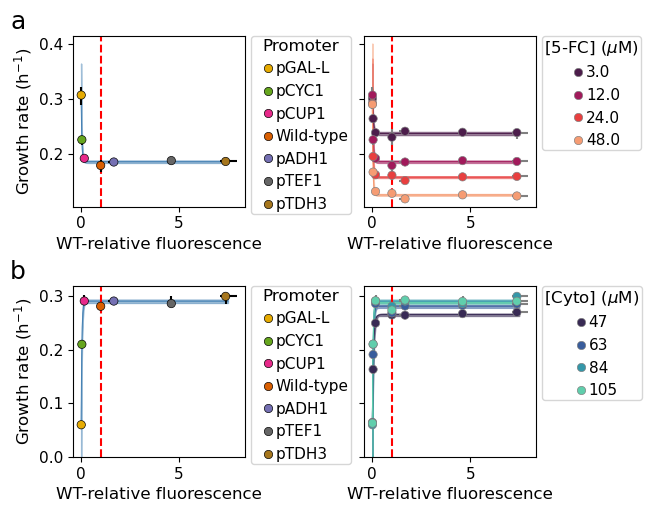

In [198]:
# Constructing the figure
fig, axs = plt.subplots(2, 2, figsize=(6.4, 5), constrained_layout=True, sharey='row')

# Top: 5-FC
# Left side: Fit at 12 uM (close to IC50)
screen_conc = fit_exp_5FC[fit_exp_5FC['[5-FC] (uM)'] == 12].copy().reset_index(drop=True)
x_screen = np.array([screen_conc['Median_Median_rel_exp'] - screen_conc['Min_Median_rel_exp'], screen_conc['Max_Median_rel_exp'] - screen_conc['Median_Median_rel_exp']])
y_screen = np.array([screen_conc['Median_Max_log_rate'] - screen_conc['Min_Max_log_rate'], screen_conc['Max_Max_log_rate'] - screen_conc['Median_Max_log_rate']])

sns.scatterplot(data=screen_conc, x='Median_Median_rel_exp', y='Median_Max_log_rate', hue='Label', ax=axs[0,0], palette=dark2_palette, zorder=3, edgecolor='black')
axs[0,0].errorbar(screen_conc['Median_Median_rel_exp'], screen_conc['Median_Max_log_rate'], xerr=x_screen, yerr=y_screen, fmt='none', zorder=2, ecolor='black')
axs[0,0].plot(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC['Median_decay_5FC_12'], c="steelblue", zorder=1, linewidth=0.75,)
axs[0,0].fill_between(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC['decay_5FC_12_2_5'],
                      curves_ci_5FC['decay_5FC_12_97_5'], alpha=0.5, color="steelblue", zorder=0)
axs[0,0].axvline(x=1, linestyle='--', color='red', zorder=1)
h_0, l_0 = axs[0,0].get_legend_handles_labels()
axs[0,0].legend(h_0, l_0, handletextpad=-0.5, loc='upper left', title='Promoter', title_fontsize=12,
                bbox_to_anchor=(1.02, 1.01), fontsize=11, borderaxespad=0.15, borderpad=0.15)
axs[0,0].set_ylabel(r"Growth rate (h$^{-1}$)", fontsize=12)
axs[0,0].set_xlabel("WT-relative fluorescence", fontsize=12)
axs[0,0].tick_params(axis='both', labelsize=11)

# Right side: All concentrations of 5-FC
fit_exp_5FC = fit_exp_5FC.sort_values(by='[5-FC] (uM)')
sns.scatterplot(data=fit_exp_5FC, x='Median_Median_rel_exp', y='Median_Max_log_rate', hue='[5-FC] (uM)', ax=axs[0,1], palette=fc_palette, zorder=3, edgecolor='grey')

n_conc = 0
for fc_conc in [3, 12, 24, 48]:
    conc_data = fit_exp_5FC[fit_exp_5FC['[5-FC] (uM)'] == fc_conc].copy().reset_index(drop=True)
    x_conc = np.array([conc_data['Median_Median_rel_exp'] - conc_data['Min_Median_rel_exp'], conc_data['Max_Median_rel_exp'] - conc_data['Median_Median_rel_exp']])
    y_conc = np.array([conc_data['Median_Max_log_rate'] - conc_data['Min_Max_log_rate'], conc_data['Max_Max_log_rate'] - conc_data['Median_Max_log_rate']])
    axs[0,1].errorbar(conc_data['Median_Median_rel_exp'], conc_data['Median_Max_log_rate'], xerr=x_conc, yerr=y_conc, fmt='none', zorder=2, ecolor='grey')
    axs[0,1].plot(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC[f'Median_decay_5FC_{fc_conc}'], c=fc_palette[n_conc], zorder=1, linewidth=0.75)
    axs[0,1].fill_between(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC[f'decay_5FC_{fc_conc}_2_5'],
                          curves_ci_5FC[f'decay_5FC_{fc_conc}_97_5'], alpha=0.5, color=fc_palette[n_conc], zorder=0)
    n_conc += 1

axs[0,1].axvline(x=1, linestyle='--', color='red', zorder=1)
h_1, l_1 = axs[0,1].get_legend_handles_labels()
axs[0,1].legend(h_1, l_1, handletextpad=-0.5, loc='upper left', title=r"[5-FC] ($\mu$M)", title_fontsize=12,
                bbox_to_anchor=(1.02, 1.01), fontsize=11, borderaxespad=0.15, borderpad=0.15)
axs[0,1].set_xlabel("WT-relative fluorescence", fontsize=12)
axs[0,1].tick_params(axis='both', labelsize=11)



# Bottom: Cytosine
# Left side: Fit at 84 uM (close to IC50)
IC50 = fit_exp_cyto[fit_exp_cyto['[Cytosine] (uM)'] == 84].copy().reset_index(drop=True)
x_IC50 = np.array([IC50['Median_Median_rel_exp'] - IC50['Min_Median_rel_exp'], IC50['Max_Median_rel_exp'] - IC50['Median_Median_rel_exp']])
y_IC50 = np.array([IC50['Median_Max_log_rate'] - IC50['Min_Max_log_rate'], IC50['Max_Max_log_rate'] - IC50['Median_Max_log_rate']])

sns.scatterplot(data=IC50, x='Median_Median_rel_exp', y='Median_Max_log_rate', hue='Label', ax=axs[1,0], palette=dark2_palette, zorder=3, edgecolor='black')
axs[1,0].errorbar(IC50['Median_Median_rel_exp'], IC50['Median_Max_log_rate'], xerr=x_IC50, yerr=y_IC50, fmt='none', zorder=2, ecolor='black')
axs[1,0].plot(curves_ci_cyto['Median_rel_exp'], curves_ci_cyto['Median_decay_cyto_84'], c="steelblue", zorder=1, linewidth=0.75)
axs[1,0].fill_between(curves_ci_cyto['Median_rel_exp'], curves_ci_cyto['decay_cyto_84_2_5'],
                      curves_ci_cyto['decay_cyto_84_97_5'], alpha=0.5, color="steelblue", zorder=0)
axs[1,0].axvline(x=1, linestyle='--', color='red', zorder=1)
h_2, l_2 = axs[1,0].get_legend_handles_labels()
axs[1,0].legend(h_2, l_2, handletextpad=-0.5, loc='upper left', title='Promoter', title_fontsize=12,
              bbox_to_anchor=(1.02, 1.01), fontsize=11, borderaxespad=0.15, borderpad=0.15)
axs[1,0].set_ylabel(r"Growth rate (h$^{-1}$)", fontsize=12)
axs[1,0].set_xlabel("WT-relative fluorescence", fontsize=12)
axs[1,0].tick_params(axis='both', labelsize=11)
axs[1,0].set_ylim(bottom=0)

# Right side: All curves in cytosine
fit_exp_cyto = fit_exp_cyto.sort_values(by='[Cytosine] (uM)')
sns.scatterplot(data=fit_exp_cyto, x='Median_Median_rel_exp', y='Median_Max_log_rate', hue='[Cytosine] (uM)', ax=axs[1,1], palette=cyto_palette, zorder=3, edgecolor='grey')

n_conc = 0
for cyto_conc in [47, 63, 84, 105]:
    conc_data = fit_exp_cyto[fit_exp_cyto['[Cytosine] (uM)'] == cyto_conc].copy().reset_index(drop=True)
    x_conc = np.array([conc_data['Median_Median_rel_exp'] - conc_data['Min_Median_rel_exp'], conc_data['Max_Median_rel_exp'] - conc_data['Median_Median_rel_exp']])
    y_conc = np.array([conc_data['Median_Max_log_rate'] - conc_data['Min_Max_log_rate'], conc_data['Max_Max_log_rate'] - conc_data['Median_Max_log_rate']])
    axs[1,1].errorbar(conc_data['Median_Median_rel_exp'], conc_data['Median_Max_log_rate'], xerr=x_conc, yerr=y_conc, fmt='none', zorder=2, ecolor='grey')
    axs[1,1].plot(curves_ci_cyto['Median_rel_exp'], curves_ci_cyto[f'Median_decay_cyto_{cyto_conc}'], c=cyto_palette[n_conc], zorder=1, linewidth=0.75)
    axs[1,1].fill_between(curves_ci_cyto['Median_rel_exp'], curves_ci_cyto[f'decay_cyto_{cyto_conc}_2_5'],
                          curves_ci_cyto[f'decay_cyto_{cyto_conc}_97_5'], alpha=0.5, color=cyto_palette[n_conc], zorder=0)
    n_conc += 1

axs[1,1].axvline(x=1, linestyle='--', color='red', zorder=1)
h_3, l_3 = axs[1,1].get_legend_handles_labels()
axs[1,1].legend(h_3, l_3, handletextpad=-0.5, loc='upper left', title=r"[Cyto] ($\mu$M)", title_fontsize=12,
                bbox_to_anchor=(1.02, 1.01), fontsize=11, borderaxespad=0.15, borderpad=0.15)
axs[1,1].set_xlabel("WT-relative fluorescence", fontsize=12)
axs[1,1].tick_params(axis='both', labelsize=11)

# Annotating the panels
axs[0,0].annotate('a', (-45.5, 128), fontsize=18, xycoords='axes points', annotation_clip=False)
axs[1,0].annotate('b', (-45.5, 128), fontsize=18, xycoords='axes points', annotation_clip=False)

figS19 = plt.gcf()
figS19.savefig(f"Supp_Figs/FigS19.tiff", bbox_inches='tight')

### S20 Fig: Bootstrapped fitness estimates at 12 uM 5-FC

In [200]:
# Preparing a df with the top three selection coefficients for each approach
top3_decay = s_predict_F3F4.copy().sort_values(by='Median_decay_5FC_12', ascending=False).reset_index(drop=True).head(3)
top3_decay = top3_decay.sort_values(by='FCY1_position')
top3_makima = s_predict_F3F4.copy().sort_values(by='Median_makima_5FC_12', ascending=False).reset_index(drop=True).head(3)
top3_makima = top3_makima.sort_values(by='FCY1_position')

# Updating the genotype ids for the figure
for row in range(3):
    id_decay = top3_decay.at[row, 'Genotype'] 
    top3_decay.at[row, 'Genotype'] = f'{id_decay[0]}_{int(top3_decay.at[row, 'FCY1_position'])}_{id_decay.split('_')[2]}'
    id_makima = top3_makima.at[row, 'Genotype'] 
    top3_makima.at[row, 'Genotype'] = f'{id_makima[0]}_{int(top3_makima.at[row, 'FCY1_position'])}_{id_makima.split('_')[2]}'

# Preparing the dataframe to compare with validation mutants
s_valid_comp['T_insertion_FCY1'] = s_valid_comp['T_insertion_FCY1'].apply(lambda x: 'Single mutant' if x=='False' else 'T insertion')

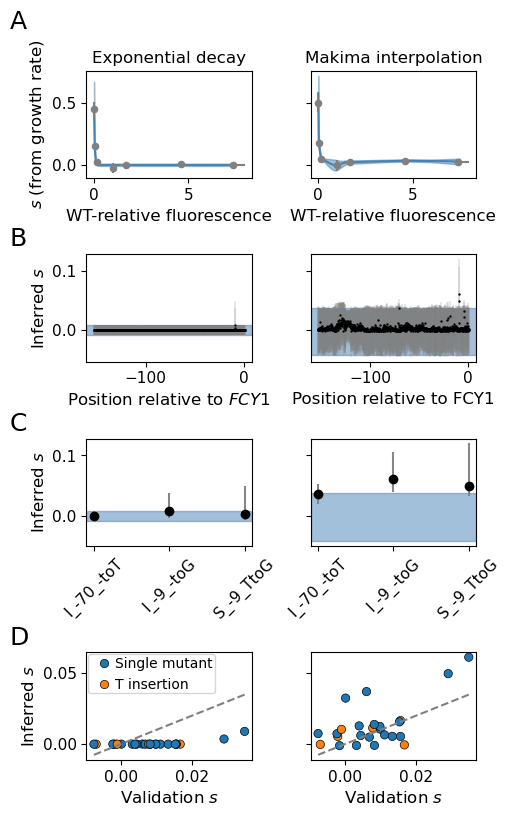

In [201]:
# Constructing the figure
fig, axs = plt.subplots(4, 2, figsize=(5, 8), constrained_layout=True, sharey='row')

# Top: plotting the curves
# For exp decay
axs[0,0].scatter(proms_s_decay['Median_Median_rel_exp'], proms_s_decay['Median_Max_log_rate'], c='grey', zorder=3, s=20)
axs[0,0].errorbar(proms_s_decay['Median_Median_rel_exp'], proms_s_decay['Median_Max_log_rate'], xerr=fluo_err, yerr=s_decay_err,
                  fmt='none', zorder=2, ecolor='grey')
axs[0,0].plot(s_curve['Median_rel_exp'], s_curve['Median_decay_5FC_12'], c="steelblue", zorder=1)
axs[0,0].fill_between(s_curve['Median_rel_exp'], s_curve['decay_5FC_12_2_5'], s_curve['decay_5FC_12_97_5'], alpha=0.5, color="steelblue",
                      zorder=0)
axs[0,0].set_xlabel(r"WT-relative fluorescence")
axs[0,0].set_ylabel(r"$s$ (from growth rate)")
axs[0,0].set_title('Exponential decay')

# For makima interpolation
axs[0,1].scatter(proms_s_makima['Median_Median_rel_exp'], proms_s_makima['Median_Max_log_rate'], c='grey', zorder=3, s=20)
axs[0,1].errorbar(proms_s_makima['Median_Median_rel_exp'], proms_s_makima['Median_Max_log_rate'], xerr=fluo_err, yerr=s_makima_err,
                  fmt='none', zorder=2, ecolor='grey')
axs[0,1].plot(s_curve['Median_rel_exp'], s_curve['Median_makima_5FC_12'], c="steelblue", zorder=1)
axs[0,1].fill_between(s_curve['Median_rel_exp'], s_curve['makima_5FC_12_2_5'], s_curve['makima_5FC_12_97_5'], alpha=0.5, color="steelblue",
                    zorder=0)
axs[0,1].set_xlabel(r"WT-relative fluorescence")
axs[0,1].set_title('Makima interpolation')

# Second row: All s from the curve
# Exponential decay fit function
axs[1,0].scatter(s_predict_F3F4['FCY1_position'], s_predict_F3F4['Median_decay_5FC_12'], c='black', s=0.5, alpha=1, zorder=2)
axs[1,0].errorbar(s_predict_F3F4['FCY1_position'], s_predict_F3F4['Median_decay_5FC_12'],
                  yerr=mut_err_decay, c='grey', linewidth=0.35, alpha=0.75, fmt='none', zorder=1)

axs[1,0].axhspan(ymin=lower_decay, ymax=upper_decay, color='steelblue', alpha=0.5, zorder=0)

axs[1,0].set_xlabel(r"Position relative to $\it{FCY1}$")
axs[1,0].set_ylabel(r"Inferred $s$")

# Makima interpolation fit function
axs[1,1].scatter(s_predict_F3F4['FCY1_position'], s_predict_F3F4['Median_makima_5FC_12'], c='black', s=0.5, alpha=1, zorder=2)
axs[1,1].errorbar(s_predict_F3F4['FCY1_position'], s_predict_F3F4['Median_makima_5FC_12'],
                yerr=mut_err_makima, c='grey', linewidth=0.35, alpha=0.75, fmt='none', zorder=1)

axs[1,1].axhspan(ymin=lower_makima, ymax=upper_makima, color='steelblue', alpha=0.5, zorder=0)

axs[1,1].set_xlabel('Position relative to FCY1')

# Third row: Top 3 selection coefficients
axs[2,0].scatter(top3_decay['Genotype'], top3_decay['Median_decay_5FC_12'], c='black', alpha=1, zorder=2)
yerr_3decay = np.array([top3_decay['Median_decay_5FC_12'] - top3_decay['decay_5FC_12_2_5'],
                        top3_decay['decay_5FC_12_97_5'] - top3_decay['Median_decay_5FC_12']])
axs[2,0].errorbar(top3_decay['Genotype'], top3_decay['Median_decay_5FC_12'],
                  yerr=yerr_3decay, c='grey', linewidth=1.5, alpha=0.95, fmt='none', zorder=1)
axs[2,0].axhspan(ymin=lower_decay, ymax=upper_decay, color='steelblue', alpha=0.5, zorder=0)
axs[2,0].tick_params(axis='x', labelrotation=45)
axs[2,0].set_ylabel(r"Inferred $s$")


axs[2,1].scatter(top3_makima['Genotype'], top3_makima['Median_makima_5FC_12'], c='black', alpha=1, zorder=2)
yerr_3makima = np.array([top3_makima['Median_makima_5FC_12'] - top3_makima['makima_5FC_12_2_5'],
                         top3_makima['makima_5FC_12_97_5'] - top3_makima['Median_makima_5FC_12']])
axs[2,1].errorbar(top3_makima['Genotype'], top3_makima['Median_makima_5FC_12'],
                  yerr=yerr_3makima, c='grey', linewidth=1.5, alpha=0.95, fmt='none', zorder=1)
axs[2,1].axhspan(ymin=lower_makima, ymax=upper_makima, color='steelblue', alpha=0.5, zorder=0)
axs[2,1].tick_params(axis='x', labelrotation=45)

# Fourth row: Correlations between selection coefficients
sns.scatterplot(data=s_valid_comp[s_valid_comp['Mutant_id'] != 'F3'], x='s_log', y='Median_decay_5FC_12', hue='T_insertion_FCY1', ax=axs[3,0],
               edgecolor='black')
axs[3,0].set_ylabel(r"Inferred $s$")
axs[3,0].set_xlabel(r"Validation $s$")
diag_vals = np.linspace(np.min(s_valid_comp[s_valid_comp['Mutant_id'] != 'F3']['s_log']), np.max(s_valid_comp[s_valid_comp['Mutant_id'] != 'F3']['s_log']), 20)
axs[3,0].plot(diag_vals, diag_vals, linestyle='--', c='grey')

h_comp, l_comp= axs[3,0].get_legend_handles_labels()
axs[3,0].legend(h_comp, l_comp, title='', loc="upper left",
                      handletextpad=-0.25, borderaxespad=0.15, borderpad=0.15)

sns.scatterplot(data=s_valid_comp[s_valid_comp['Mutant_id'] != 'F3'], x='s_log', y='Median_makima_5FC_12', hue='T_insertion_FCY1', ax=axs[3,1], legend=False,
               edgecolor='black')
axs[3,1].plot(diag_vals, diag_vals, linestyle='--', c='grey')
axs[3,1].set_xlabel(r"Validation $s$")

# Annotating the panels
axs[0,0].annotate('A', (-55, 107.5), fontsize=18, xycoords='axes points', annotation_clip=False)
axs[1,0].annotate('B', (-55, 83), fontsize=18, xycoords='axes points', annotation_clip=False)
axs[2,0].annotate('C', (-55, 83), fontsize=18, xycoords='axes points', annotation_clip=False)
axs[3,0].annotate('D', (-55, 83), fontsize=18, xycoords='axes points', annotation_clip=False)

figS20 = plt.gcf()
figS20.savefig(f"Supp_Figs/FigS20.tiff", bbox_inches='tight')

## Exporting a cleaner version of fit_exp_comp as Supp Table 11

In [203]:
supp11 = pd.merge(med_s_5FC, sort_comp[['Genotype', 'T_insertion', 'Relative_median_exp',
                                        'Max_rel_exp', 'Min_rel_exp', 'Mutation type',
                                        'In_F3F4', 'FCY1_position']],
                  on=['Genotype'], how='right', suffixes=('_FCY1', '_42-GFP'))

supp11 = supp11[['Mutant_id', 'Genotype', 'Mutation type', 'FCY1_position', 'In_F3F4',
                 'T_insertion_FCY1', 'Max_log_rate', 's_log',
                 'Min_Max_log_rate', 'Min_s_log', 'Max_Max_log_rate', 'Max_s_log',
                 'T_insertion_42-GFP', 'Relative_median_exp', 'Max_rel_exp','Min_rel_exp']].copy()
supp11.to_csv("Supp_data/SuppTable11.csv")